## 따릉이 대여량 예측 모델링

1. 2017.12.1~2018.10.31 (treain)까지의 따릉이 대여량 및 날씨, 계절, 기온 등의 데이터를 기반으로 2018년 11월(test) 따릉이 대여량 예측하기

- train.csv  : 2017.12.01 ~ 2018.10.31 까지 데이터 (훈련 데이터)
- test.csv : “대여량” 변수가 없는 데이터셋
- train.csv 는 새로운 데이터셋으로 모델 성능을 평가할 수 있습니다. train.csv 로 학습을 진행해주시고, 가장 성능이 좋았던 모델로 test.csv 를 예측해보시면 됩니다.


In [146]:
import pandas as pd
import koreanize_matplotlib     
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#test,train 셋 불러오기
train = pd.read_csv('C:/Users/minmi/Downloads/train.csv')
test = pd.read_csv('C:/Users/minmi/Downloads/test.csv')


print(train.head())
print(test.head())

         Date  Rented Bike Count  Hour  Temperature(째C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(째C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               NaN              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0     NaN  No Holiday   


In [147]:
#칼럼 확인하기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8040 non-null   object 
 1   Rented Bike Count          8040 non-null   int64  
 2   Hour                       8040 non-null   int64  
 3   Temperature(째C)            7240 non-null   float64
 4   Humidity(%)                8040 non-null   int64  
 5   Wind speed (m/s)           7238 non-null   float64
 6   Visibility (10m)           8040 non-null   int64  
 7   Dew point temperature(째C)  8040 non-null   float64
 8   Solar Radiation (MJ/m2)    8040 non-null   float64
 9   Rainfall(mm)               8040 non-null   float64
 10  Snowfall (cm)              8040 non-null   float64
 11  Seasons                    7238 non-null   object 
 12  Holiday                    8040 non-null   object 
 13  Functioning Day            8040 non-null   objec

**변수 설명**
1. Date :날짜
2. Rented Bike Count :대여된 자전거 수
3. Hour :시간
4. Temperature (°C) :온도
5. Humidity (%) :습도
6. Wind speed (m/s) :풍속
7. Visibility (10m) :가시거리
8. Dew point temperature (°C) :이슬점 온도
9. Solar Radiation (MJ/m2) :태양 복사량
10. Rainfall (mm) :강우량
11. Snowfall (cm) :적설량
12. seasons :계절
13. Holiday :휴일 여부
14. Functioning Day :정상 운영일 여부

In [148]:
#훈련셋 행/열 확인
train.shape

(8040, 14)

In [149]:
#결측값 확인
train.isna().sum()

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(째C)              800
Humidity(%)                    0
Wind speed (m/s)             802
Visibility (10m)               0
Dew point temperature(째C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      802
Holiday                        0
Functioning Day                0
dtype: int64

In [150]:
train.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(째C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(째C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

## 결측값 처리
주요 결측값이 존재하는 변수는 Temperature(°C), Wind speed (m/s), Seasons이다. 

**결측값 대체**
- Temperature(°C),Wind speed (m/s): 계절에 따라, 시간대에 따라 큰 변화를 보이기 때문에, 각 계절과 시간대에 따른 평균온도와 풍속으로 결측치를 대체하는 방법을 사용한다.
- Seasons: Date 칼럼을 이용해 보완하고자 한다.

### seasons 결측치 처리
- 봄(Spring): 3월 1일 ~ 5월 31일
- 여름(Summer): 6월 1일 ~ 8월 31일
- 가을(Fall): 9월 1일 ~ 11월 30일
- 겨울(Winter): 12월 1일 ~ 2월 28일(또는 29일)

In [151]:
# 1. Date 칼럼을 datetime 타입으로 변환
train['Date'] = pd.to_datetime(train['Date'], format='%d/%m/%Y')

In [152]:
# 2. 날짜에 따라 계절을 반환하는 함수 정의
def get_season(date):
    if date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

In [153]:
# 3. 결측치 처리: Date를 이용해 Seasons 보완
train['Seasons'] = train['Seasons'].fillna(train['Date'].apply(get_season))

# 결과 확인
print(train['Seasons'].isna().sum())  # 결측치가 0임을 확인


0


### Temperature(°C)와 Wind speed (m/s) 결측치 처리

In [154]:
# 1. 계절과 시간대별 평균값 계산
season_hour_temp_avg = train.groupby(['Seasons', 'Hour'])['Temperature(째C)'].mean()
season_hour_wind_avg = train.groupby(['Seasons', 'Hour'])['Wind speed (m/s)'].mean()

print(season_hour_temp_avg)
print(season_hour_wind_avg)


Seasons  Hour
Autumn   0       15.612500
         1       15.300000
         2       15.624528
         3       14.549123
         4       14.082353
                   ...    
Winter   19      -1.413580
         20      -1.921176
         21      -2.424051
         22      -2.630864
         23      -3.179268
Name: Temperature(째C), Length: 96, dtype: float64
Seasons  Hour
Autumn   0       1.152830
         1       1.171154
         2       0.974074
         3       0.913725
         4       1.026923
                   ...   
Winter   19      2.086585
         20      1.898795
         21      1.913953
         22      1.890123
         23      1.729487
Name: Wind speed (m/s), Length: 96, dtype: float64


In [155]:
# 2. Temperature 결측치 대체 함수
def fill_missing_temperature(row):
    if pd.isna(row['Temperature(째C)']):
        return season_hour_temp_avg.get((row['Seasons'], row['Hour']), train['Temperature(째C)'].mean())
    else:
        return row['Temperature(째C)']

# 3. Wind speed 결측치 대체 함수
def fill_missing_wind_speed(row):
    if pd.isna(row['Wind speed (m/s)']):
        return season_hour_wind_avg.get((row['Seasons'], row['Hour']), train['Wind speed (m/s)'].mean())
    else:
        return row['Wind speed (m/s)']

In [156]:
# 4. 결측치 대체 실행
train['Temperature(째C)'] = train.apply(fill_missing_temperature, axis=1)
train['Wind speed (m/s)'] = train.apply(fill_missing_wind_speed, axis=1)

# 결과 확인
print(train[['Temperature(째C)', 'Wind speed (m/s)']].isna().sum())

Temperature(째C)     0
Wind speed (m/s)    0
dtype: int64


In [157]:
#결측치가 모두 없음을 확인
train.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(째C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(째C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

### 온도와 풍속 결측치 처리 후 시각화

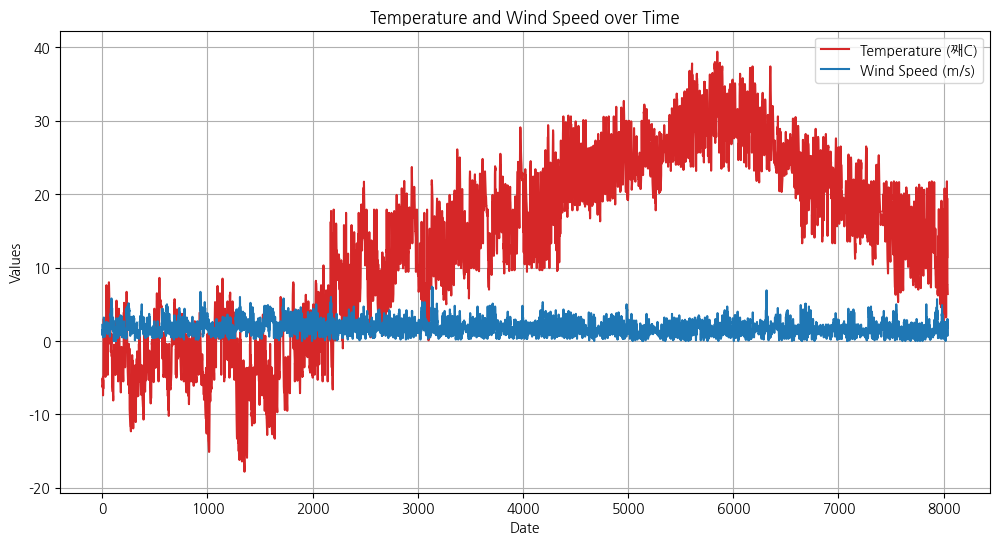

In [158]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature(째C)'], label='Temperature (째C)', color='tab:red')
plt.plot(train.index, train['Wind speed (m/s)'], label='Wind Speed (m/s)', color='tab:blue')

# 3. 그래프 설정
plt.title('Temperature and Wind Speed over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## 범주형 변수 인코딩
- Seasons, Holiday, Functioning Day를 인코딩하고자 한다

In [159]:
train['Holiday'].value_counts() #이진변수

No Holiday    7608
Holiday        432
Name: Holiday, dtype: int64

In [160]:
train['Functioning Day'].value_counts() #이진변수

Yes    7817
No      223
Name: Functioning Day, dtype: int64

In [161]:
train['Seasons'].value_counts()

Spring    2208
Summer    2208
Winter    2160
Autumn    1464
Name: Seasons, dtype: int64

Spring → 0
Summer → 1
Fall → 2
Winter → 3
으로 원하는 순서대로 라벨 매핑을 원하기에 밑에 방법으로 수행되었다.

In [162]:
# Autumn을 Fall로 바꾸기
train['Seasons'] = train['Seasons'].replace('Autumn', 'Fall')


In [163]:
# 원하는 순서대로 계절 정렬
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# 수동 매핑하여 Seasons 칼럼에 바로 적용
train['Seasons'] = train['Seasons'].map({season: i for i, season in enumerate(season_order)})

# 결과 확인
print("최종 매핑 확인:", train['Seasons'].unique())


최종 매핑 확인: [3 0 1 2]


In [164]:
#이진변수로 변환
train['Holiday'] = train['Holiday'].apply(lambda x: 1 if x == 'Holiday' else 0)

In [165]:
train['Functioning Day'] = train['Functioning Day'].apply(lambda x: 1 if x == 'Yes' else 0)

In [166]:
print(train[['Holiday', 'Functioning Day', 'Seasons']].head())

   Holiday  Functioning Day  Seasons
0        0                1        3
1        0                1        3
2        0                1        3
3        0                1        3
4        0                1        3


## 변수별 이상치 확인

In [167]:
train.describe()

,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
count,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000
mean,709.775995,11.500000,13.389800,58.271020,1.754756,1459.170896,4.522239,0.587072,0.152164,0.066493,1.444776,0.053731,0.972264
std,657.320605,6.922617,12.175222,20.340492,1.005452,603.716284,13.393517,0.886186,1.127026,0.378182,1.154852,0.225501,0.164227
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.100000,43.000000,1.000000,977.000000,-4.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,485.000000,11.500000,15.500000,57.000000,1.600000,1741.000000,6.400000,0.020000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1080.500000,17.250000,23.198837,74.000000,2.300000,2000.000000,15.600000,0.960000,0.000000,0.000000,3.000000,0.000000,1.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000,3.000000,1.000000,1.000000


## STL Decomposition을 이용하여 이상치 탐지
- 시계열 데이터를 계절성, 추세, 잔차로 분리하여 잔차가 큰 값을 이상치로 간주한다.

In [168]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8040 non-null   datetime64[ns]
 1   Rented Bike Count          8040 non-null   int64         
 2   Hour                       8040 non-null   int64         
 3   Temperature(째C)            8040 non-null   float64       
 4   Humidity(%)                8040 non-null   int64         
 5   Wind speed (m/s)           8040 non-null   float64       
 6   Visibility (10m)           8040 non-null   int64         
 7   Dew point temperature(째C)  8040 non-null   float64       
 8   Solar Radiation (MJ/m2)    8040 non-null   float64       
 9   Rainfall(mm)               8040 non-null   float64       
 10  Snowfall (cm)              8040 non-null   float64       
 11  Seasons                    8040 non-null   int64         
 12  Holida

## 온도 이상치 탐색

In [169]:
 #1. 계절성 분해 (3개월 주기 사용)
from statsmodels.tsa.seasonal import seasonal_decompose
    
decomp_result = seasonal_decompose(train['Temperature(째C)'], model='additive', period=2160)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

Detected 20 outliers out of 5880 data points (0.34% 이상치)


<Figure size 1000x800 with 0 Axes>

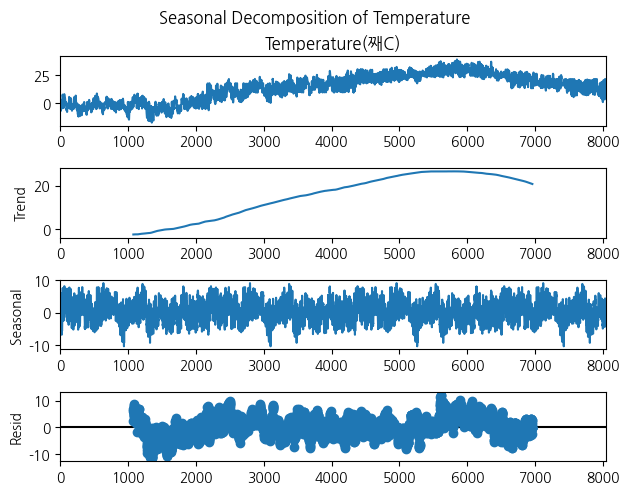

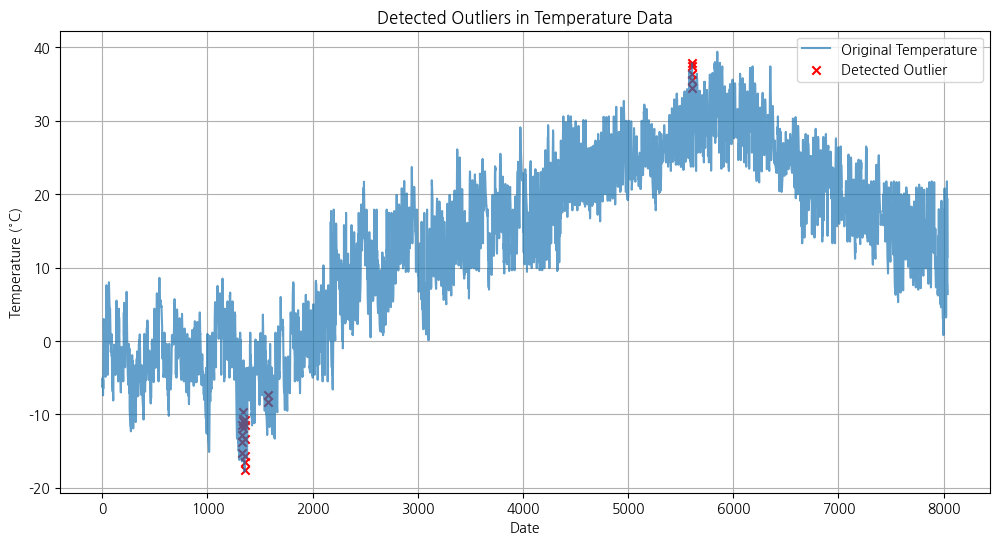

In [170]:
# STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Temperature', y=1.02)
plt.show()

# 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature(째C)'], label='Original Temperature', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, train.loc[outliers.index, 'Temperature(째C)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Detected Outliers in Temperature Data')
plt.grid(True)
plt.show()

- Observed (원본 데이터)
- 시간에 따라 측정된 실제 온도(°C) 데이터
- 여름철에는 기온이 상승하고, 겨울철에는 하락하는 뚜렷한 계절 패턴이 나타남 

- Trend (추세)
- 시간에 따른 장기적인 온도 변화를 나타냄.
- 그래프에서 보면 초반에는 기온이 점진적으로 증가하고, 이후 감소하는 경향이 있다. 

- Seasonal (계절성 패턴)
- 3개월 주기로 반복되는 계절성 변동을 나타냄. 
- 여름철에는 높은 온도가 반복되고, 겨울철에는 낮은 온도가 주기적으로 나타나는 것을 확인할 수 있다.

- Residual (잔차)
- 계절성과 추세를 제거한 후 남은 변동입니다. 잔차가 큰 부분은 예측할 수 없는 변동 또는 이상치일 가능성이 높다.

빨간 점 (Detected Outlier): 이상치로 탐지된 값입니다.

여름철(기온이 높은 시기)에 집중적으로 이상치가 탐지된 것을 확인할 수 있습니다.

In [171]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = train.loc[outliers.index]

# 결과 출력
print("Detected Outlier Rows:")
print(outlier_rows)

Detected Outlier Rows:
           Date  Rented Bike Count  Hour  Temperature(째C)  Humidity(%)  \
1330 2018-01-25                105    10            -15.3           33   
1331 2018-01-25                122    11            -13.8           25   
1332 2018-01-25                142    12            -12.8           25   
1333 2018-01-25                130    13            -11.4           27   
1335 2018-01-25                130    15             -9.7           28   
1337 2018-01-25                170    17            -10.9           32   
1338 2018-01-25                288    18            -11.8           33   
1353 2018-01-26                149     9            -17.5           37   
1354 2018-01-26                 96    10            -16.5           33   
1355 2018-01-26                 93    11            -15.6           31   
1357 2018-01-26                115    13            -13.3           28   
1359 2018-01-26                140    15            -11.4           27   
1360 2018-01-26

온도 데이터에서 이상치가 겨울(-15°C 이하)과 여름(35°C 이상)에 집중되어 있다.
겨울철: -15°C 이하로 내려가는 것은 한파일 수 있음
여름철: 35°C 이상의 값은 폭염일 가능성이 큽니다

=> 해당 이상치는 그대로 두기로 한다.

## 습도 이상치 탐색

In [172]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. 계절성 분해 (3개월 주기 사용)
decomp_result = seasonal_decompose(train['Humidity(%)'], model='additive', period=2160)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")


Detected 20 outliers out of 5880 data points (0.34% 이상치)


<Figure size 1000x800 with 0 Axes>

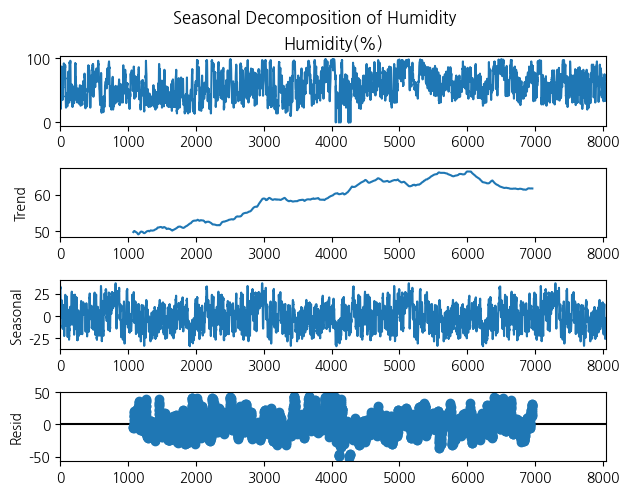

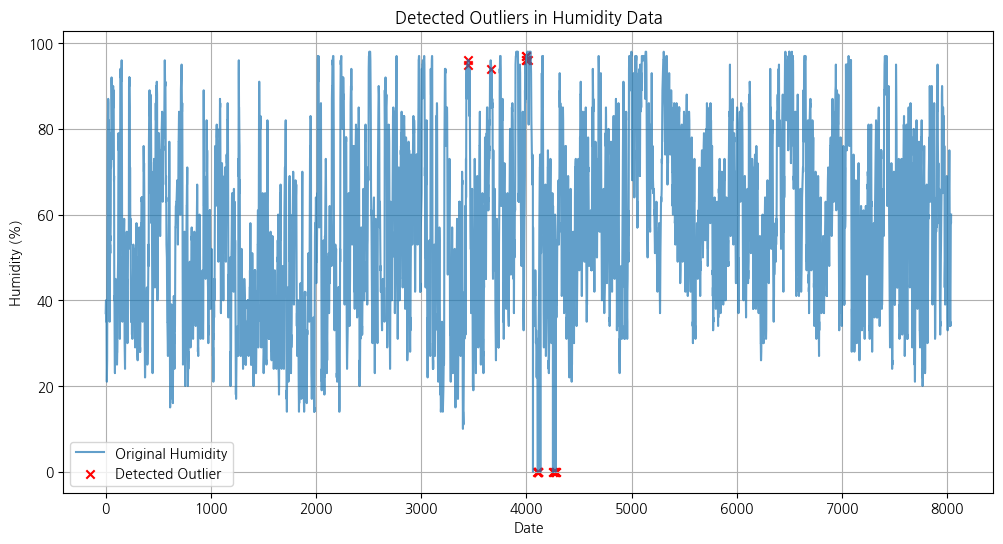

In [173]:
#  STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Humidity', y=1.02)
plt.show()

# 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Humidity(%)'], label='Original Humidity', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, train.loc[outliers.index, 'Humidity(%)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Detected Outliers in Humidity Data')
plt.grid(True)
plt.show()

- 원본 데이터 :일정한 변동폭을 유지하고 있음
- 추세 : 4000번째쯤에 급격히 증가했다가 하락하는 경향이 보임
- 계절성: 습도가 낮아졌다 높아지는 패턴이 나타남
- 잔차: 이상치로 탐지될만한 데이터가 나타남 -> 폭우나 습도 변화

In [174]:
# 이상치 발생 시점의 습도와 강수량 데이터를 추출
outlier_data = train.loc[outliers.index, ['Humidity(%)', 'Rainfall(mm)']]

# 이상치 데이터 출력
print("Humidity Outliers with Rainfall Data:")
print(outlier_data)


Humidity Outliers with Rainfall Data:
      Humidity(%)  Rainfall(mm)
3445           95           2.5
3446           96           4.0
3662           94           0.0
3997           97          35.0
3998           96           0.0
3999           96           0.0
4000           97           0.0
4020           96           1.5
4106            0           0.0
4107            0           0.0
4108            0           0.0
4109            0           0.0
4110            0           0.0
4111            0           0.0
4253            0           0.0
4255            0           0.0
4276            0           0.0
4277            0           0.0
4278            0           0.0
4279            0           0.0


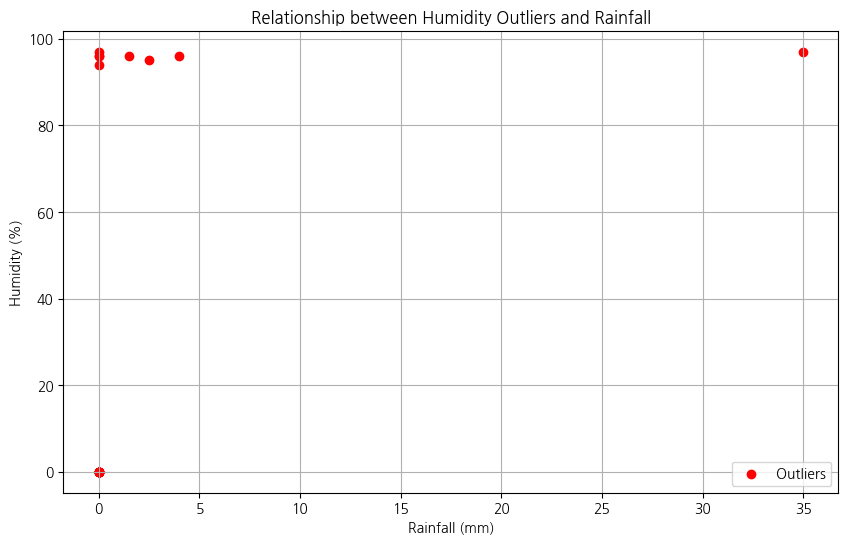

In [175]:
# 습도 이상치와 강수량 간의 시각화
plt.figure(figsize=(10, 6))
plt.scatter(outlier_data['Rainfall(mm)'], outlier_data['Humidity(%)'], color='red', label='Outliers')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Humidity (%)')
plt.title('Relationship between Humidity Outliers and Rainfall')
plt.legend()
plt.grid(True)
plt.show()

In [176]:
# 상관계수 계산
correlation = outlier_data['Humidity(%)'].corr(outlier_data['Rainfall(mm)'])
print(f"Correlation between Humidity Outliers and Rainfall: {correlation:.2f}")
# 이상치의 습도와 강우량은 상관관계가 의미있다고 하긴 어려움

Correlation between Humidity Outliers and Rainfall: 0.35


3445번, 3446번, 3997번 등의 데이터에서 습도가 95~97%로 매우 높은 수준이며 동시에 강수량이 2.5mm, 4.0mm, 35.0mm로 비가 내리고 있는 것을 확인할 수 있습니다.

**이상치 처리 방안**
1. 습도 0% 처리 - 선형보간법을 통한 대체
2. 높은 습도와 비가 함께 있는 경우 (정상으로 간주)
3. 강우량이 0인데 습도가 높은 경우는 안개나 이슬, 지형적 특성이 있을 수 있으므로 이상치를 유지하도록 한다.

In [177]:
# 0% 습도 이상치를 선형 보간으로 대체
train.loc[train['Humidity(%)'] == 0, 'Humidity(%)'] = train['Humidity(%)'].replace(0, np.nan).interpolate()

## 풍속 이상치 탐색

In [178]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. 계절성 분해 (3개월 주기 사용)
decomp_result = seasonal_decompose(train['Wind speed (m/s)'], model='additive', period=2160)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")


Detected 47 outliers out of 5880 data points (0.80% 이상치)


<Figure size 1000x800 with 0 Axes>

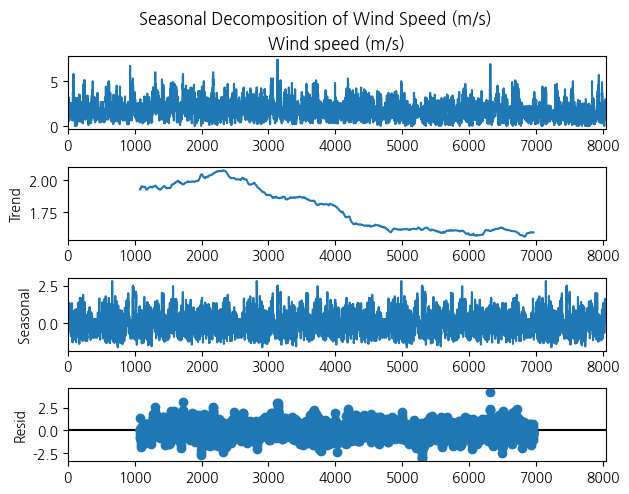

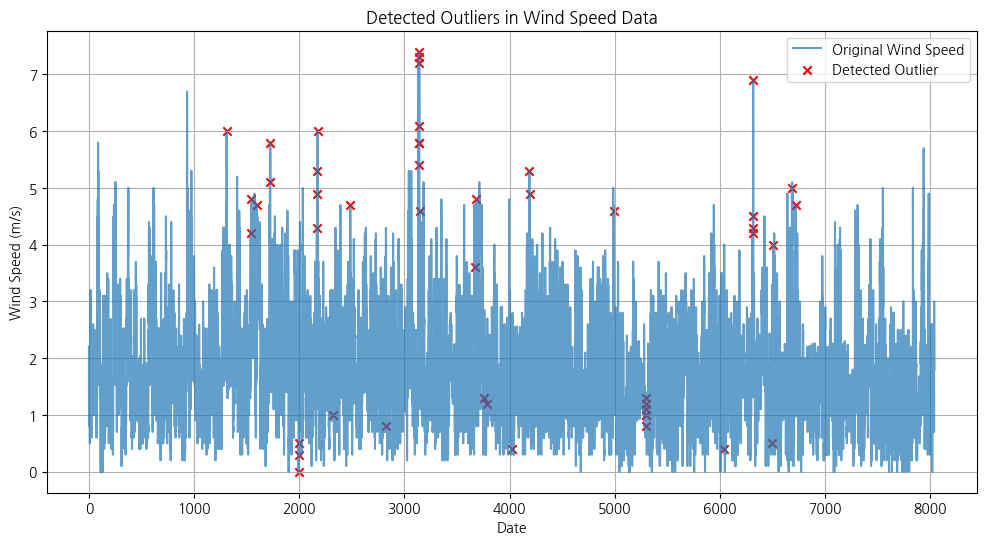

In [179]:
# STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Wind Speed (m/s)', y=1.02)
plt.show()

# 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Wind speed (m/s)'], label='Original Wind Speed', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, train.loc[outliers.index, 'Wind speed (m/s)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Detected Outliers in Wind Speed Data')
plt.grid(True)
plt.show()


2. 추세에서 점진적으로 증가하다가 감소하는 경향이 보임

In [180]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = train.loc[outliers.index]

# 결과 출력
print("Detected Outlier Rows:")
print(outlier_rows)

Detected Outlier Rows:
           Date  Rented Bike Count  Hour  Temperature(째C)  Humidity(%)  \
1309 2018-01-24                140    13       -12.000000         25.0   
1538 2018-02-03                123     2        -3.400000         82.0   
1542 2018-02-03                 33     6        -7.800000         57.0   
1595 2018-02-05                156    11        -8.500000         27.0   
1723 2018-02-10                151    19        -3.100000         14.0   
1724 2018-02-10                132    20        -4.400000         19.0   
1994 2018-02-22                116     2        -3.654545         57.0   
1995 2018-02-22                 71     3        -2.800000         57.0   
1996 2018-02-22                 66     4        -4.600000         58.0   
2167 2018-03-01                 61     7         2.600000         89.0   
2169 2018-03-01                160     9         0.100000         78.0   
2170 2018-03-01                191    10         0.100000         53.0   
2174 2018-03-01

**이상치 처리**
1. 강수량이 2mm 이상인데도 풍속이 **비정상적으로 낮은 경우(1.0m/s 이하)**->보간법
2. 풍속이 0인 경우 ->선형 보간법
3. 가시거리가 낮고 풍속이 낮은 경우 -> 안개, 기압 변화일 수 있으므로 이상치로 간주하지 않음

In [181]:
# 풍속이 비정상적으로 낮은 시점 보간 처리
low_wind_indices = train[(train['Rainfall(mm)'] > 2) & (train['Wind speed (m/s)'] <= 1)].index
train.loc[low_wind_indices, 'Wind speed (m/s)'] = train['Wind speed (m/s)'].interpolate(method='linear')

In [182]:
# 풍속 0m/s인 데이터 선형 보간
train.loc[train['Wind speed (m/s)'] == 0, 'Wind speed (m/s)'] = train['Wind speed (m/s)'].replace(0, np.nan).interpolate()

## 가시거리 이상치 탐색

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. 계절성 분해 (3개월 주기 사용)
decomp_result = seasonal_decompose(train['Visibility (10m)'], model='additive', period=2160)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

Detected 4 outliers out of 5880 data points (0.07% 이상치)


<Figure size 1000x800 with 0 Axes>

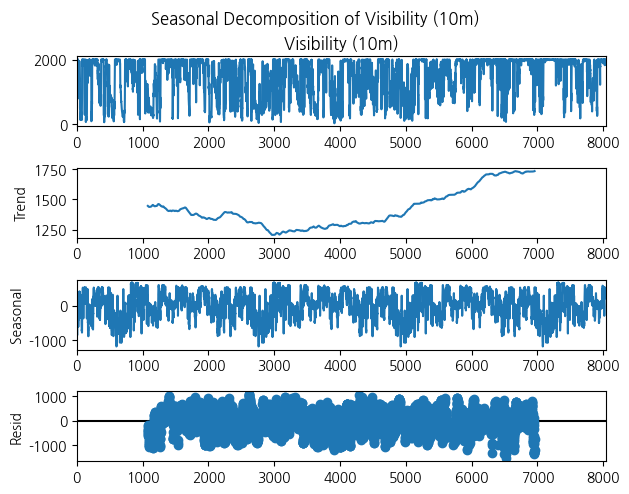

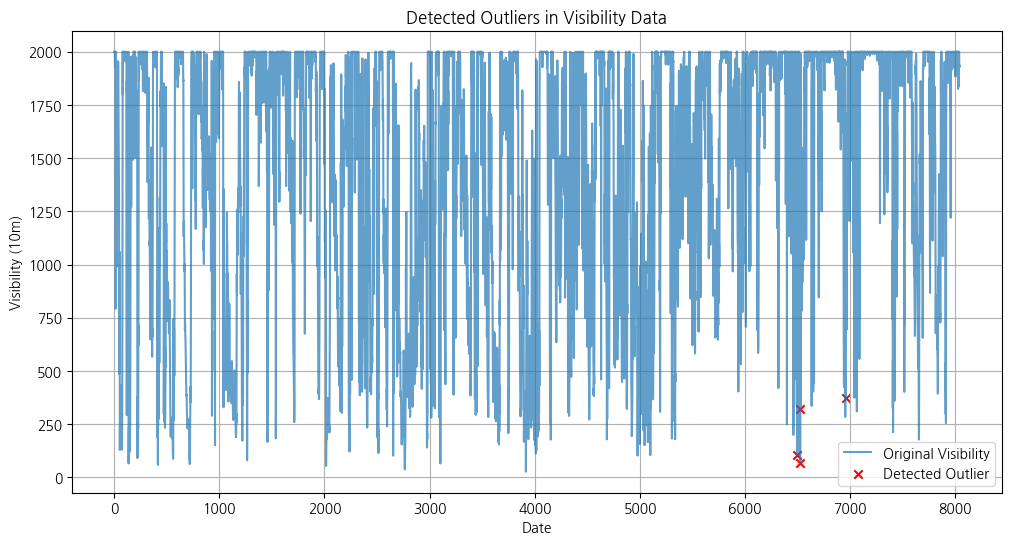

In [184]:
# STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Visibility (10m)', y=1.02)
plt.show()

# 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Visibility (10m)'], label='Original Visibility', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, train.loc[outliers.index, 'Visibility (10m)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Visibility (10m)')
plt.title('Detected Outliers in Visibility Data')
plt.grid(True)
plt.show()

In [185]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = train.loc[outliers.index]

# 결과 출력
print("Detected Outlier Rows:")
print(outlier_rows)

Detected Outlier Rows:
           Date  Rented Bike Count  Hour  Temperature(째C)  Humidity(%)  \
6498 2018-08-28                 96    18             24.3         97.0   
6523 2018-08-29                 24    19             23.5         97.0   
6524 2018-08-29                 19    20             23.4         98.0   
6957 2018-09-16               1146    21             21.2         88.0   

      Wind speed (m/s)  Visibility (10m)  Dew point temperature(째C)  \
6498               0.8               105                       23.7   
6523               0.3               323                       22.9   
6524               0.6                70                       23.0   
6957               1.7               373                       19.1   

      Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  \
6498                     0.01          18.5            0.0        1        0   
6523                     0.00           6.5            0.0        1        0   
6524      

**이상치 처리 방안**
- 6498은 강한 비가 내리는 상황에서 가시거리가 매우 낮을 수 있기에 -> 이상치 처리X
- 6523은 비가 내리고 습도가 높으며 가시거리가 낮음-> 이상치 처리X
- 6524은 매우 많은 비(21mm)가 내리는 상황에서 가시거리가 낮음->이상치 처리X
- 6957은 비가 내리지 않는데도 가시거리가 낮음-> 보간법

In [186]:
# 이상치 중 센서 오류로 의심되는 가시거리 데이터를 선형 보간으로 대체
train.loc[[6957], 'Visibility (10m)'] = train['Visibility (10m)'].interpolate(method='linear')

## 이슬점 온도 이상치 탐색

In [187]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. STL 계절성 분해 (3개월 주기 사용)
decomp_result = seasonal_decompose(train['Dew point temperature(째C)'], model='additive', period=2160)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")


Detected 1 outliers out of 5880 data points (0.02% 이상치)


<Figure size 1000x800 with 0 Axes>

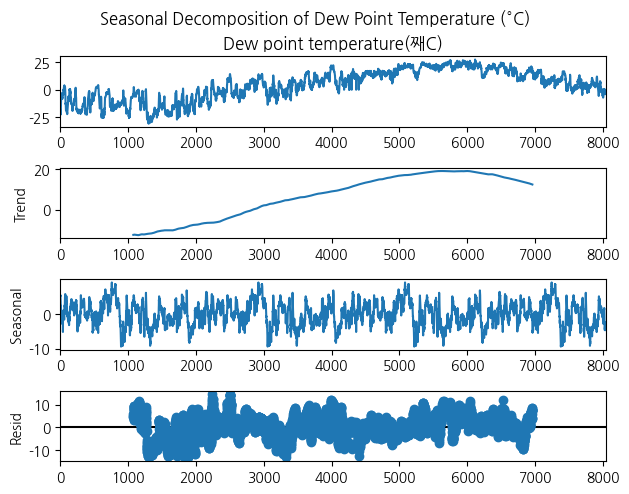

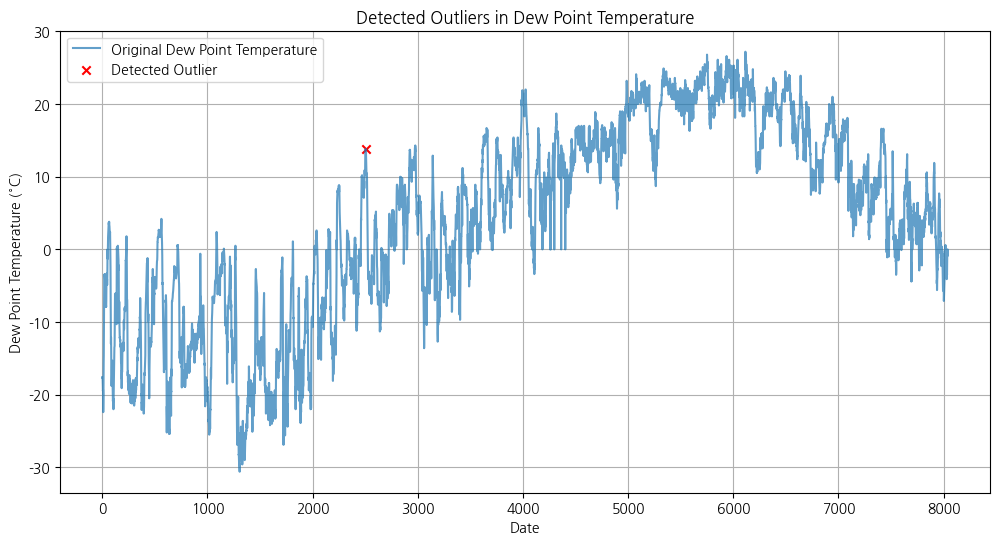

In [188]:
#  STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Dew Point Temperature (°C)', y=1.02)
plt.show()

# 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Dew point temperature(째C)'], label='Original Dew Point Temperature', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, train.loc[outliers.index, 'Dew point temperature(째C)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Dew Point Temperature (°C)')
plt.title('Detected Outliers in Dew Point Temperature')
plt.grid(True)
plt.show()

In [189]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = train.loc[outliers.index]

# 결과 출력
print("Detected Outlier Rows:")
print(outlier_rows)

Detected Outlier Rows:
           Date  Rented Bike Count  Hour  Temperature(째C)  Humidity(%)  \
2503 2018-03-15                 15     7             14.3         97.0   

      Wind speed (m/s)  Visibility (10m)  Dew point temperature(째C)  \
2503               0.3               189                       13.8   

      Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  \
2503                      0.0           0.0            0.0        0        0   

      Functioning Day  
2503                1  


**이상치 처리**
- 안개, 이슬, 대기 포화 상태에서는 정상으로 볼 수 있지만, 가시거리가 비정상적이며 풍속이 비정상적으로 낮아서 삭제하는 것이 좋다는 판단을 했다.


In [190]:
# 이상치 행 삭제
train = train.drop(2503)
print(f"이상치 데이터 삭제 후 데이터 크기: {train.shape}")

이상치 데이터 삭제 후 데이터 크기: (8039, 14)


## 태양 복사량 이상치 탐색

In [191]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. STL 계절성 분해 (3개월 주기 사용)
decomp_result = seasonal_decompose(train['Solar Radiation (MJ/m2)'], model='additive', period=2160)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

Detected 84 outliers out of 5879 data points (1.43% 이상치)


<Figure size 1000x800 with 0 Axes>

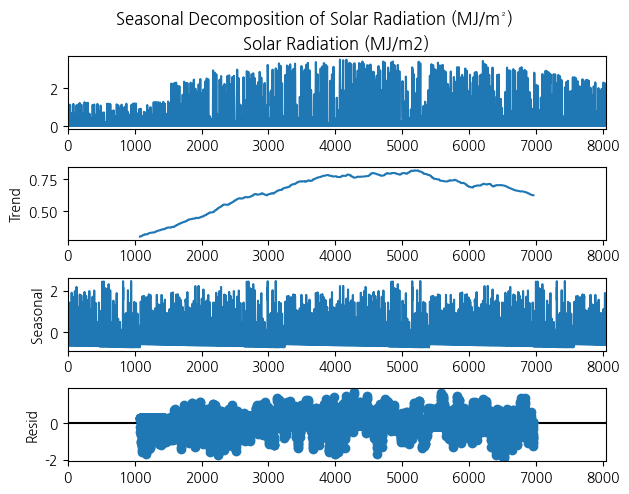

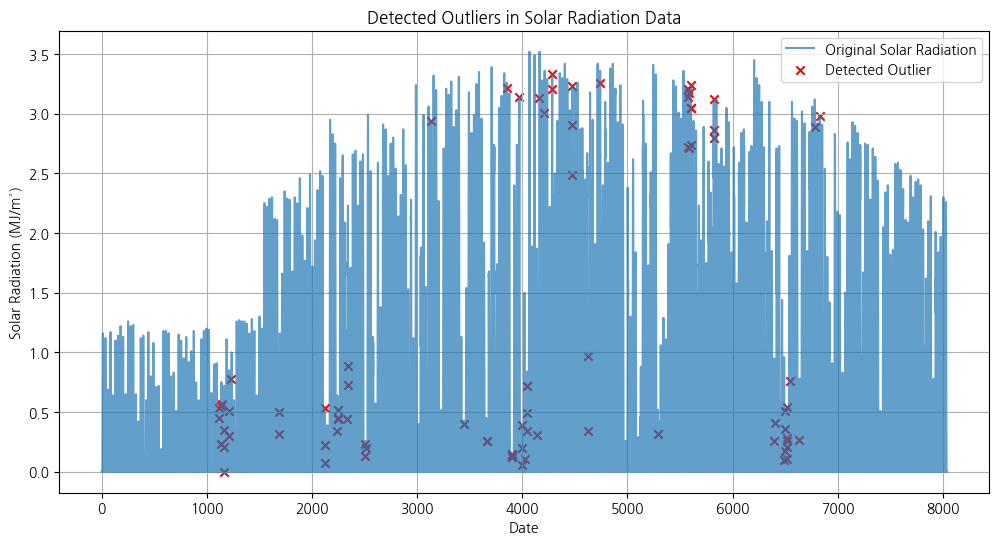

In [192]:
#STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Solar Radiation (MJ/m²)', y=1.02)
plt.show()

#이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Solar Radiation (MJ/m2)'], label='Original Solar Radiation', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, train.loc[outliers.index, 'Solar Radiation (MJ/m2)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Solar Radiation (MJ/m²)')
plt.title('Detected Outliers in Solar Radiation Data')
plt.grid(True)
plt.show()


In [193]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = train.loc[outliers.index]
# 결과 출력

pd.DataFrame(outlier_rows)

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
1116,2018-01-16,276,12,5.200000,52.0,1.200000,349,-3.8,0.45,0.0,0.0,3,0,1
1117,2018-01-16,296,13,5.800000,47.0,2.524691,382,-4.6,0.53,0.0,0.0,3,0,1
1138,2018-01-17,212,10,4.300000,58.0,0.500000,401,-3.2,0.23,0.0,0.0,3,0,1
1139,2018-01-17,270,11,6.000000,51.0,1.000000,436,-3.3,0.55,0.0,0.0,3,0,1
1141,2018-01-17,273,13,0.354762,54.0,1.800000,435,-0.7,0.57,0.0,0.0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6520,2018-08-29,193,16,27.000000,76.0,3.800000,1875,22.3,0.21,0.0,0.0,1,0,1
6542,2018-08-30,837,14,27.500000,66.0,2.800000,989,20.5,0.76,0.0,0.0,1,0,1
6636,2018-09-03,673,12,23.900000,83.0,1.100000,1901,20.8,0.27,0.0,0.0,2,0,1
6780,2018-09-09,1220,12,25.900000,39.0,1.200000,1950,10.8,2.89,0.0,0.0,2,0,1


**이상치 처리**
- 태양 복사량이 0 또는 비정상적으로 낮은 경우:
    - 밤 시간대(0으로 나오는 것이 정상)는 그대로 유지합니다.
    - 낮 시간대(햇볕이 있어야 하는 시간에 0 또는 비정상적으로 낮음)일 경우 센서 오류 가능성이 높습니다.
- 낮 시간대(6시~18시)이며 강우량이 있는 경우 -> 정상 이상치


In [194]:
# 밤 시간대(19시~23시, 0시~5시)이며 태양 복사량이 비정상적으로 높은 경우 탐지
night_high_solar_outliers = outliers[
    (train.loc[outliers.index, 'Hour'].between(19, 23) | 
     train.loc[outliers.index, 'Hour'].between(0, 5)) & 
    (train.loc[outliers.index, 'Solar Radiation (MJ/m2)'] > 0.2)  # 임계치 설정 (예: 0.5 이상일 경우 삭제)
].index

print(night_high_solar_outliers) # 없음

Int64Index([], dtype='int64')


In [195]:
# 낮 시간대(6시~18시)이며 강우량이 있는 경우의 낮은 태양 복사량 탐지
rain_related_low_solar = outliers[
    (train.loc[outliers.index, 'Hour'].between(6, 18)) & 
    (train.loc[outliers.index, 'Solar Radiation (MJ/m2)'] <= 0.5) &  # 낮은 태양 복사량 (임계치 설정)
    (train.loc[outliers.index, 'Rainfall(mm)'] > 0)  # 강우량이 있는 경우
].index

print(f"강우량과 연관된 낮은 태양 복사량 {len(rain_related_low_solar)}개를 정상 데이터로 간주하고 유지합니다.")


강우량과 연관된 낮은 태양 복사량 15개를 정상 데이터로 간주하고 유지합니다.


In [196]:
# 태양 복사량 이상치 중 낮 시간대(6시~18시)인 경우 탐지
solar_outliers = outliers[(train.loc[outliers.index, 'Hour'].between(6, 18)) & 
                          (train.loc[outliers.index, 'Solar Radiation (MJ/m2)'] == 0)].index

print(f"Detected {len(solar_outliers)} potential solar radiation errors during daytime among the existing outliers.")
# 낮 시간대 태양 복사량 이상치 삭제
train = train.drop(solar_outliers)
print(f"이상치 데이터 삭제 후 데이터 크기: {train.shape}")


Detected 1 potential solar radiation errors during daytime among the existing outliers.
이상치 데이터 삭제 후 데이터 크기: (8038, 14)


낮시간대 0인 경우를 삭제한거를 제외하고 대부분이 이상치가 아니여서 그대로 유지했다.

## 강우량 이상치 탐색

In [197]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. STL 계절성 분해 (3개월 주기 사용)
decomp_result = seasonal_decompose(train['Rainfall(mm)'], model='additive', period=2160)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")


Detected 99 outliers out of 5878 data points (1.68% 이상치)


<Figure size 1000x800 with 0 Axes>

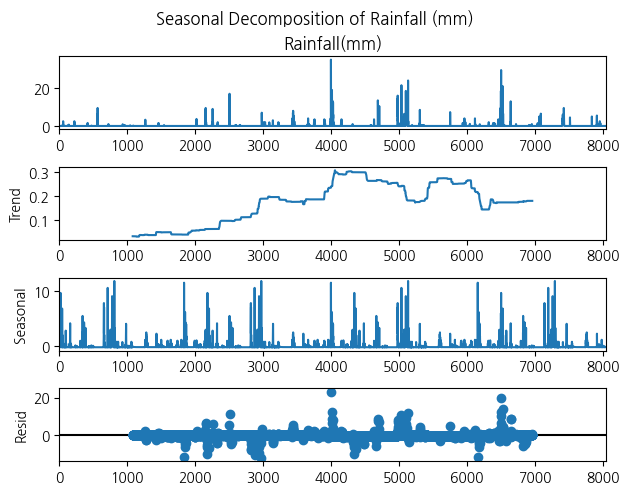

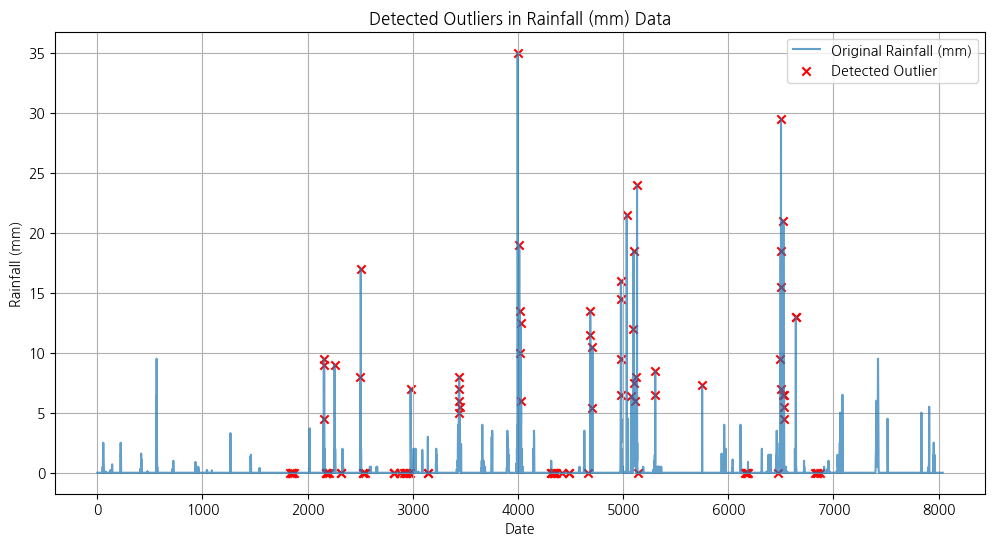

In [198]:
# STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Rainfall (mm)', y=1.02)
plt.show()

# 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Rainfall(mm)'], label='Original Rainfall (mm)', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, train.loc[outliers.index, 'Rainfall(mm)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Detected Outliers in Rainfall (mm) Data')
plt.grid(True)
plt.show()

In [199]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = train.loc[outliers.index]
# 결과 출력

pd.DataFrame(outlier_rows)

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
1836,2018-02-15,174,12,-0.389333,20.0,3.000000,1983,-18.9,2.28,0.0,0.0,3,1,1
1851,2018-02-16,36,3,-4.400000,37.0,1.494872,1989,-16.9,0.00,0.0,0.0,3,1,1
1855,2018-02-16,49,7,-5.400000,41.0,0.300000,2000,-16.6,0.00,0.0,0.0,3,1,1
1856,2018-02-16,68,8,-5.400000,38.0,0.700000,2000,-17.5,0.04,0.0,0.0,3,1,1
1867,2018-02-16,126,19,0.600000,59.0,2.300000,1939,-6.5,0.00,0.0,0.0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6642,2018-09-03,113,18,21.900000,97.0,1.800000,757,21.3,0.02,13.0,0.0,2,0,1
6825,2018-09-11,1234,9,19.800000,49.0,1.900000,2000,8.7,1.24,0.0,0.0,2,0,1
6847,2018-09-12,1551,7,16.800000,61.0,1.300000,2000,9.2,0.06,0.0,0.0,2,0,1
6848,2018-09-12,2391,8,14.323214,56.0,1.500000,1994,9.2,0.62,0.0,0.0,2,0,1


**이상치 제거**
- 강우량이 많으나 태양 복사량이 비정상적으로 높거나 습도가 낮은 경우 -> 이상치 삭제
- 여름철에 장마철이 포함되므로 강우량이 많은 날이 여름이면 -> 이상치 유지


In [200]:
# 강우량 이상치 탐지 조건: 강우량이 많으나 태양 복사량이 비정상적으로 높거나 습도가 낮은 경우
rainfall_outliers_advanced = train[
    ((train['Rainfall(mm)'] > 2) & (train['Solar Radiation (MJ/m2)'] > 0.5)) |  # 강우량이 많을 때 태양 복사량이 높은 경우
    ((train['Rainfall(mm)'] > 2) & (train['Humidity(%)'] < 50)) |  # 강우량이 많으나 습도가 낮은 경우
    ((train['Rainfall(mm)'] > 2) & (train['Visibility (10m)'] > 1500))  # 강우량이 많으나 가시거리가 높은 경우
]

print(f"{len(rainfall_outliers_advanced)}")

11


In [201]:
# 이상치 데이터 삭제
train_cleaned = train.drop(rainfall_outliers_advanced.index)
print(f"제거 후 {train_cleaned.shape}")

제거 후 (8027, 14)


## 적설량 이상치 탐색

In [202]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. STL 계절성 분해 (3개월 주기 사용)
decomp_result = seasonal_decompose(train['Snowfall (cm)'], model='additive', period=2160)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")


Detected 117 outliers out of 5878 data points (1.99% 이상치)


<Figure size 1000x800 with 0 Axes>

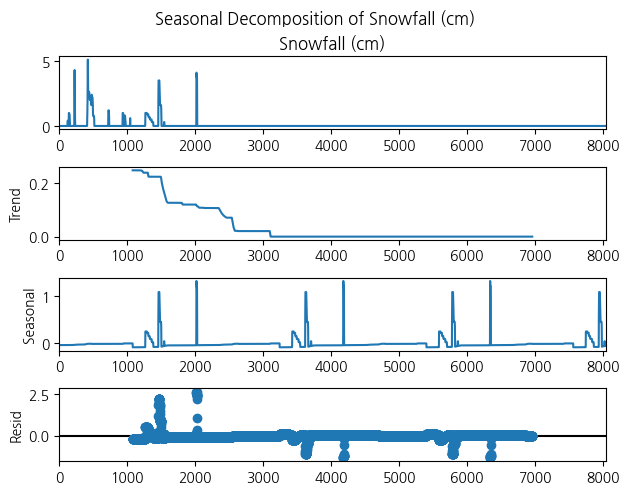

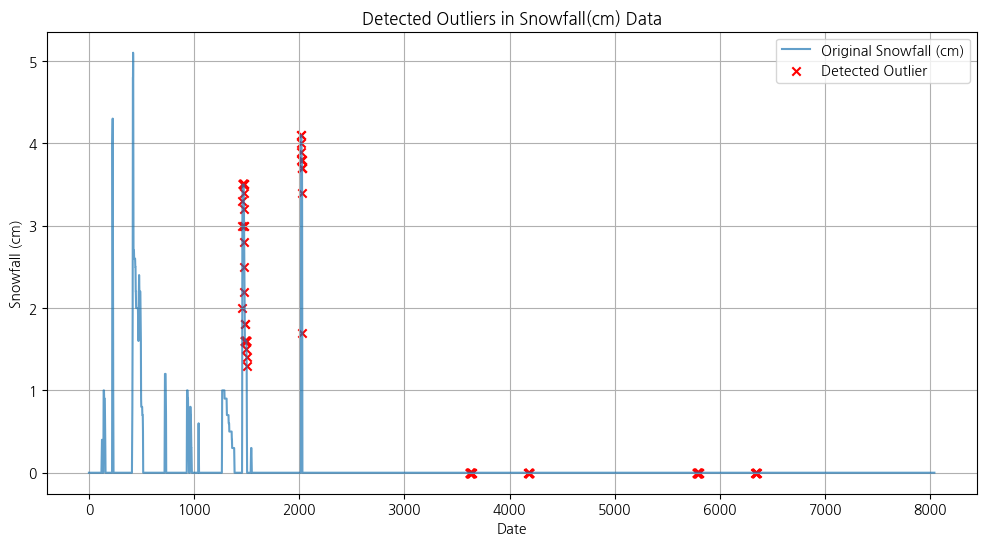

In [203]:
# STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Snowfall (cm)', y=1.02)
plt.show()

# 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Snowfall (cm)'], label='Original Snowfall (cm)', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, train.loc[outliers.index, 'Snowfall (cm)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Snowfall (cm)')
plt.title('Detected Outliers in Snowfall(cm) Data')
plt.grid(True)
plt.show()

In [204]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = train.loc[outliers.index]
# 결과 출력

a=pd.DataFrame(outlier_rows)
a[a['Seasons']==3] #대부분 겨울철에 이상치 값으로 판단되었으므로 이건 정상적인 패턴일 가능성이 있기에 제거하지 않는다

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
1458,2018-01-30,100,18,-2.300000,91.0,2.387179,202,-3.5,0.00,1.4,2.0,3,0,1
1459,2018-01-30,59,19,-1.700000,91.0,2.086585,167,-2.9,0.00,0.0,3.0,3,0,1
1460,2018-01-30,72,20,-1.500000,91.0,1.700000,270,-2.7,0.00,0.0,3.3,3,0,1
1461,2018-01-30,60,21,-1.600000,91.0,1.300000,508,-2.8,0.00,1.5,3.5,3,0,1
1462,2018-01-30,73,22,-1.700000,85.0,1.890123,1006,-3.8,0.00,0.0,3.5,3,0,1
1463,2018-01-30,62,23,-1.700000,83.0,1.000000,1093,-4.2,0.00,0.0,3.5,3,0,1
1464,2018-01-31,69,0,-1.700000,83.0,0.800000,1113,-4.2,0.00,0.0,3.5,3,0,1
1465,2018-01-31,96,1,-1.600000,81.0,1.100000,1141,-4.4,0.00,0.0,3.5,3,0,1
1466,2018-01-31,60,2,-1.600000,80.0,1.400000,1097,-4.6,0.00,0.0,3.5,3,0,1
1467,2018-01-31,47,3,-4.593671,83.0,1.494872,977,-4.7,0.00,0.0,3.5,3,0,1


In [205]:
a[a['Seasons']==1]

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
5780,2018-07-29,1697,20,32.300000,48.0,1.400000,2000,19.8,0.08,0.0,0.0,1,0,1
5781,2018-07-29,1638,21,31.100000,47.0,1.300000,2000,18.4,0.00,0.0,0.0,1,0,1
5782,2018-07-29,1406,22,30.400000,45.0,1.600000,2000,17.1,0.00,0.0,0.0,1,0,1
5783,2018-07-29,1108,23,29.900000,45.0,1.400000,2000,16.6,0.00,0.0,0.0,1,0,1
5784,2018-07-30,810,0,29.200000,50.0,1.100000,2000,17.7,0.00,0.0,0.0,1,0,1
5785,2018-07-30,575,1,28.500000,54.0,1.100000,2000,18.2,0.00,0.0,0.0,1,0,1
5786,2018-07-30,363,2,28.000000,57.0,1.125000,2000,18.6,0.00,0.0,0.0,1,0,1
5787,2018-07-30,253,3,27.400000,59.0,1.098750,2000,18.6,0.00,0.0,0.0,1,0,1
5788,2018-07-30,209,4,26.700000,62.0,1.000000,2000,18.8,0.00,0.0,0.0,1,0,1
5789,2018-07-30,273,5,23.198837,62.0,0.600000,2000,18.5,0.00,0.0,0.0,1,0,1


In [206]:
a[a['Seasons']==0]

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
3620,2018-04-30,1703,20,13.302381,69.0,2.400000,533,14.1,0.00,0.0,0.0,0,0,1
3621,2018-04-30,1711,21,19.100000,73.0,1.200000,413,14.1,0.00,0.0,0.0,0,0,1
3622,2018-04-30,1456,22,18.400000,78.0,1.600000,377,14.4,0.00,0.0,0.0,0,0,1
3623,2018-04-30,1044,23,17.900000,79.0,0.400000,323,14.1,0.00,0.0,0.0,0,0,1
3624,2018-05-01,782,0,18.300000,78.0,0.800000,349,14.3,0.00,0.0,0.0,0,1,1
3625,2018-05-01,705,1,18.300000,83.0,1.100000,451,15.3,0.00,0.0,0.0,0,1,1
3626,2018-05-01,534,2,18.200000,85.0,0.800000,355,15.6,0.00,0.0,0.0,0,1,1
3627,2018-05-01,343,3,18.100000,85.0,1.000000,284,15.5,0.00,0.0,0.0,0,1,1
3628,2018-05-01,187,4,18.000000,85.0,0.300000,275,15.4,0.00,0.0,0.0,0,1,1
3629,2018-05-01,166,5,18.000000,85.0,0.800000,346,15.4,0.00,0.0,0.0,0,1,1


In [207]:
a[a['Seasons']==2]

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day


이상치 특징
- 초반 구간(겨울철)에서 강설량이 높게 기록되었다.-> 이상치 처리 안함
- 겨울을 제외한 모든 계절에서 이상치의 적설량이 0이므로-> 이상치 처리 안함


# 회귀모델 적용

In [208]:
train.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(째C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(째C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [209]:
#필요한 라이브러리
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [210]:
#독립과 종속변수 분리
features = ['Hour', 'Temperature(째C)', 'Humidity(%)', 
            'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(째C)',
            'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
            'Seasons', 'Holiday', 'Functioning Day']

X = train[features]
y = train['Rented Bike Count']

In [211]:
#데이터를 학습/검증 세트로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### 평가지표 함수 만들기

In [212]:
from sklearn.metrics import r2_score, mean_squared_error

def eval_regression(model):
    # 모델로 학습 데이터와 검증 데이터 예측 수행
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # 학습 데이터에 대한 평가
    print('학습 능력')
    print('R Square : ', r2_score(y_train, y_train_pred))
    print('MSE : ', mean_squared_error(y_train, y_train_pred))
    
    # 검증 데이터에 대한 평가 (일반화 능력)
    print('검증 능력')
    print('R Square : ', r2_score(y_val, y_val_pred))
    print('MSE : ', mean_squared_error(y_val, y_val_pred))


## 선형회귀


In [213]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error


In [214]:
# 파이프라인 구성: StandardScaler -> LinearRegression
pipe_lr = make_pipeline(StandardScaler(), LinearRegression())

In [215]:
# 하이퍼파라미터 그리드 
param_grid_lr = {
    "linearregression__fit_intercept": [True, False]
}

In [216]:
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, cv=3, scoring='r2', n_jobs=-1) #그리드서치를 통한 하이퍼파라미터튜닝
grid_lr.fit(X_train, y_train)

print("### Linear Regression ###")
print("Best Parameters:", grid_lr.best_params_)
print("Best CV R2 Score:", grid_lr.best_score_)

# 평가 함수 호출
eval_regression(grid_lr.best_estimator_)


### Linear Regression ###
Best Parameters: {'linearregression__fit_intercept': True}
Best CV R2 Score: 0.5364835204709807
학습 능력
R Square :  0.53908694161188
MSE :  197841.66728603726
검증 능력
R Square :  0.5348151216604418
MSE :  206129.32482706726


## 릿지 회귀

In [217]:
from sklearn.linear_model import Ridge

# 파이프라인 구성: StandardScaler -> Ridge
pipe_ridge = make_pipeline(StandardScaler(), Ridge(random_state=42))


In [218]:
# 하이퍼파라미터 그리드: alpha 값 튜닝
param_grid_ridge = {
    "ridge__alpha": [0.1, 1, 1.5, 2.0]
}


In [219]:
grid_ridge = GridSearchCV(pipe_ridge, param_grid=param_grid_ridge, cv=3, scoring='r2', n_jobs=-1)
grid_ridge.fit(X_train, y_train)

print("### Ridge Regression ###")
print("Best Parameters:", grid_ridge.best_params_)
print("Best CV R2 Score:", grid_ridge.best_score_)

# 평가 함수 호출
eval_regression(grid_ridge.best_estimator_)

### Ridge Regression ###
Best Parameters: {'ridge__alpha': 2.0}
Best CV R2 Score: 0.5364935498546807
학습 능력
R Square :  0.5390840450370238
MSE :  197842.91060771912
검증 능력
R Square :  0.5348987650512341
MSE :  206092.26137880597


## 라쏘 회귀

In [220]:
from sklearn.linear_model import Lasso

# 파이프라인 구성: StandardScaler -> Lasso (max_iter는 충분히 크게)
pipe_lasso = make_pipeline(StandardScaler(), Lasso(max_iter=10000, random_state=42))


In [221]:
# 하이퍼파라미터 그리드: alpha 값 튜닝
param_grid_lasso = {
    "lasso__alpha": [0.001, 0.01, 0.1, 1, 10]
}


In [222]:
grid_lasso = GridSearchCV(pipe_lasso, param_grid=param_grid_lasso, cv=3, scoring='r2', n_jobs=-1)
grid_lasso.fit(X_train, y_train)

print("### Lasso Regression ###")
print("Best Parameters:", grid_lasso.best_params_)
print("Best CV R2 Score:", grid_lasso.best_score_)

# 평가 함수 호출
eval_regression(grid_lasso.best_estimator_)

### Lasso Regression ###
Best Parameters: {'lasso__alpha': 0.1}
Best CV R2 Score: 0.536526717507694
학습 능력
R Square :  0.5390861109355454
MSE :  197842.02384436864
검증 능력
R Square :  0.5348075542675812
MSE :  206132.67803490718


## 다항회귀

In [223]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 파이프라인 구성: StandardScaler -> PolynomialFeatures -> LinearRegression
pipe_poly = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())


In [224]:
# 하이퍼파라미터 그리드: 다항 차수 튜닝 (degree 1은 선형과 동일)
param_grid_poly = {
    "polynomialfeatures__degree": [1, 2, 3]
}

In [225]:
grid_poly = GridSearchCV(pipe_poly, param_grid=param_grid_poly, cv=3, scoring='r2', n_jobs=-1)
grid_poly.fit(X_train, y_train)

print("### Polynomial Regression ###")
print("Best Parameters:", grid_poly.best_params_)
print("Best CV R2 Score:", grid_poly.best_score_)

# 평가 함수 호출
eval_regression(grid_poly.best_estimator_)

### Polynomial Regression ###
Best Parameters: {'polynomialfeatures__degree': 2}
Best CV R2 Score: 0.6758728006580093
학습 능력
R Square :  0.6887428097017549
MSE :  133603.59478363476
검증 능력
R Square :  0.6878529318969058
MSE :  138316.32839078005


## 랜덤 포레스트 회귀

In [226]:
from sklearn.ensemble import RandomForestRegressor

# 파이프라인 구성: StandardScaler -> RandomForestRegressor
pipe_rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))


In [227]:
# 하이퍼파라미터 그리드 설정
param_grid_rf = {
    "randomforestregressor__n_estimators": [50, 100, 200],
    "randomforestregressor__max_depth": [None, 5, 10],
    "randomforestregressor__min_samples_split": [2, 5, 10]
}

In [228]:
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("### Random Forest Regression ###")
print("Best Parameters:", grid_rf.best_params_)
print("Best CV R2 Score:", grid_rf.best_score_)

# 평가 함수 호출
eval_regression(grid_rf.best_estimator_)

### Random Forest Regression ###
Best Parameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 200}
Best CV R2 Score: 0.8618144708396995
학습 능력
R Square :  0.9560139914966156
MSE :  18880.491887126096
검증 능력
R Square :  0.8690540787380938
MSE :  58023.79998877045


## 결정트리회귀모델

In [229]:
from sklearn.tree import DecisionTreeRegressor

# 파이프라인 구성: StandardScaler -> DecisionTreeRegressor
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=42))

In [230]:
# 하이퍼파라미터 그리드 설정
param_grid_dt = {
    "decisiontreeregressor__max_depth": [None, 5, 10, 20],
    "decisiontreeregressor__min_samples_split": [2, 5, 10]
}

In [231]:
grid_dt = GridSearchCV(pipe_dt, param_grid=param_grid_dt, cv=3, scoring='r2', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print("### Decision Tree Regression ###")
print("Best Parameters:", grid_dt.best_params_)
print("Best CV R2 Score:", grid_dt.best_score_)

# 평가 함수 호출
eval_regression(grid_dt.best_estimator_)

### Decision Tree Regression ###
Best Parameters: {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__min_samples_split': 10}
Best CV R2 Score: 0.7941277401864371
학습 능력
R Square :  0.8873285261093947
MSE :  48362.943605997665
검증 능력
R Square :  0.8187303130573279
MSE :  80322.89939105144


## 그레디언트 부스팅 회귀

In [232]:
from sklearn.ensemble import GradientBoostingRegressor

# 파이프라인 구성: StandardScaler -> GradientBoostingRegressor
pipe_gb = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42))


In [233]:
# 하이퍼파라미터 그리드 설정
param_grid_gb = {
    "gradientboostingregressor__n_estimators": [50, 100, 200],
    "gradientboostingregressor__learning_rate": [0.01, 0.1, 0.2],
    "gradientboostingregressor__max_depth": [3, 5, 7]
}

In [234]:
# GridSearchCV 실행 (3-폴드 교차검증, scoring은 R2 사용)
grid_gb = GridSearchCV(pipe_gb, param_grid=param_grid_gb, cv=3, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train, y_train)

print("### Gradient Boosting Regression ###")
print("Best Parameters:", grid_gb.best_params_)
print("Best CV R2 Score:", grid_gb.best_score_)

# GridSearchCV를 통해 얻은 최적 모델을 이용하여 평가 함수 호출
eval_regression(grid_gb.best_estimator_)

### Gradient Boosting Regression ###
Best Parameters: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__n_estimators': 200}
Best CV R2 Score: 0.8683462226362554
학습 능력
R Square :  0.9387668269990967
MSE :  26283.640307521633
검증 능력
R Square :  0.8737932939028421
MSE :  55923.793587860084


Gradient Boosting Regression이 최고의 모델로 보인다. 
일반화 능력(R²)과 MSE에서 가장 좋은 성능을 보이므로 최적의 모델로 선택


최적의 파라미터
---
{'gradientboostingregressor__learning_rate': 0.1, 
 'gradientboostingregressor__max_depth': 5, 
 'gradientboostingregressor__n_estimators': 200}
---

In [235]:
# 변수 중요도 추출
best_model = grid_gb.best_estimator_.named_steps['gradientboostingregressor']
feature_importances = best_model.feature_importances_

In [236]:
# 변수 중요도를 정렬
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [237]:
# 변수 중요도 출력
print("\n### Feature Importances ###")
print(importance_df)


### Feature Importances ###
                      Feature  Importance
1             Temperature(째C)    0.346237
0                        Hour    0.289825
6     Solar Radiation (MJ/m2)    0.094132
11            Functioning Day    0.086300
2                 Humidity(%)    0.068956
7                Rainfall(mm)    0.044396
5   Dew point temperature(째C)    0.036200
9                     Seasons    0.011805
4            Visibility (10m)    0.011685
3            Wind speed (m/s)    0.006552
10                    Holiday    0.003623
8               Snowfall (cm)    0.000287


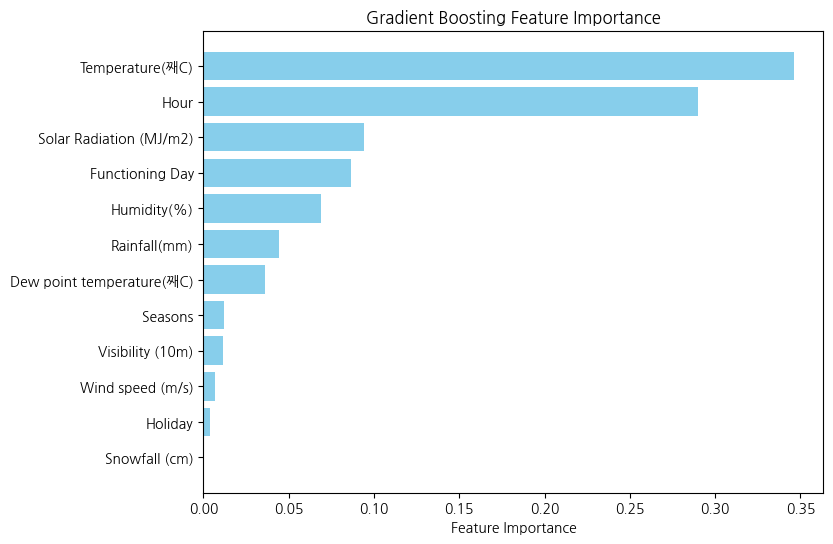

In [242]:
# 변수 중요도 시각화
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance')
plt.gca().invert_yaxis()  # 상위 중요 변수가 위로 오도록 설정
plt.show()

snowfall은 중요한 영향을 끼치지 않는다..

# 변수 제거 후 모델 평가

In [243]:
# 1. 'Snowfall (cm)' 변수 제거
X_train_dropped = X_train.drop(columns=['Snowfall (cm)'])
X_val_dropped = X_val.drop(columns=['Snowfall (cm)'])

In [244]:
# 2. Gradient Boosting Regressor 정의 (최적 하이퍼파라미터 사용)
final_model = GradientBoostingRegressor(random_state=42, n_estimators=200, max_depth=5, learning_rate=0.1)

In [245]:
# 3. 모델 학습
final_model.fit(X_train_dropped, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [246]:
# 4. 모델 평가 함수 정의
def eval_regression(model):
    # 학습 데이터 예측
    y_train_pred = model.predict(X_train_dropped)
    # 검증 데이터 예측
    y_val_pred = model.predict(X_val_dropped)

    # 평가 결과 출력
    print('학습 데이터 평가:')
    print('R Square :', r2_score(y_train, y_train_pred))
    print('MSE :', mean_squared_error(y_train, y_train_pred))
    print('\n검증 데이터 평가:')
    print('R Square :', r2_score(y_val, y_val_pred))
    print('MSE :', mean_squared_error(y_val, y_val_pred))


In [247]:
# 5. 평가 함수 호출
eval_regression(final_model)

학습 데이터 평가:
R Square : 0.9373387030444261
MSE : 26896.646207747694

검증 데이터 평가:
R Square : 0.8708141575521794
MSE : 57243.886723135314


미세한 차이이지만 변수를 제거한 모델을 평가했더니 낮은 R^2이 나왔다. 그러므로 **변수를 제거하지 않은 회귀모델이 더 좋은 모델이라고 할 수 있다.**

## test 데이터셋에 Gradient Boosting Regression 모델 적용

In [248]:
test.isna().sum()

Date                          0
Hour                          0
Temperature(째C)              76
Humidity(%)                   0
Wind speed (m/s)             74
Visibility (10m)              0
Dew point temperature(째C)     0
Solar Radiation (MJ/m2)       0
Rainfall(mm)                  0
Snowfall (cm)                 0
Seasons                      74
Holiday                       0
Functioning Day               0
dtype: int64

In [249]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       720 non-null    object 
 1   Hour                       720 non-null    int64  
 2   Temperature(째C)            644 non-null    float64
 3   Humidity(%)                720 non-null    int64  
 4   Wind speed (m/s)           646 non-null    float64
 5   Visibility (10m)           720 non-null    int64  
 6   Dew point temperature(째C)  720 non-null    float64
 7   Solar Radiation (MJ/m2)    720 non-null    float64
 8   Rainfall(mm)               720 non-null    float64
 9   Snowfall (cm)              720 non-null    float64
 10  Seasons                    646 non-null    object 
 11  Holiday                    720 non-null    object 
 12  Functioning Day            720 non-null    object 
dtypes: float64(6), int64(3), object(4)
memory usage: 7

In [250]:
test.shape

(720, 13)

위와 똑같은 전처리를 수행한다.

## 결측치 처리 - train에서 했던 전처리와 똑같이 진행

In [251]:
# 1. Date 칼럼을 datetime 타입으로 변환
test['Date'] = pd.to_datetime(test['Date'], format='%d/%m/%Y')

# 2. 날짜에 따라 계절을 반환하는 함수 정의
def get_season(date):
    if date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

# 3. 결측치 처리: Date를 이용해 Seasons 보완
test['Seasons'] = test['Seasons'].fillna(test['Date'].apply(get_season))

# 결과 확인
print(test['Seasons'].isna().sum())  # 결측치가 0임을 확인


0


## 풍속과 온도 결측치 처리

In [252]:
# 1. 계절과 시간대별 평균값 계산
season_hour_temp_avg = test.groupby(['Seasons', 'Hour'])['Temperature(째C)'].mean()
season_hour_wind_avg = test.groupby(['Seasons', 'Hour'])['Wind speed (m/s)'].mean()

# 2. Temperature 결측치 대체 함수
def fill_missing_temperature(row):
    if pd.isna(row['Temperature(째C)']):
        return season_hour_temp_avg.get((row['Seasons'], row['Hour']), test['Temperature(째C)'].mean())
    else:
        return row['Temperature(째C)']

# 3. Wind speed 결측치 대체 함수
def fill_missing_wind_speed(row):
    if pd.isna(row['Wind speed (m/s)']):
        return season_hour_wind_avg.get((row['Seasons'], row['Hour']), test['Wind speed (m/s)'].mean())
    else:
        return row['Wind speed (m/s)']

# 4. 결측치 대체 실행
test['Temperature(째C)'] = test.apply(fill_missing_temperature, axis=1)
test['Wind speed (m/s)'] = test.apply(fill_missing_wind_speed, axis=1)

# 결과 확인
print(test[['Temperature(째C)', 'Wind speed (m/s)']].isna().sum())


Temperature(째C)     0
Wind speed (m/s)    0
dtype: int64


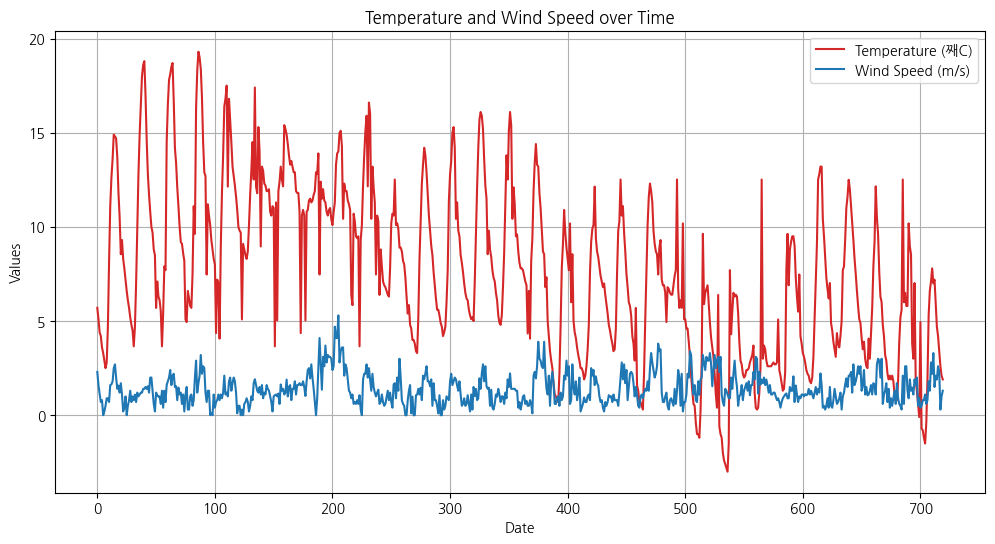

In [253]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Temperature(째C)'], label='Temperature (째C)', color='tab:red')
plt.plot(test.index, test['Wind speed (m/s)'], label='Wind Speed (m/s)', color='tab:blue')

# 3. 그래프 설정
plt.title('Temperature and Wind Speed over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## 범주형 변수 인코딩

In [254]:
# Autumn을 Fall로 바꾸기
test['Seasons'] = test['Seasons'].replace('Autumn', 'Fall')

# 원하는 순서대로 계절 정렬
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# 수동 매핑하여 Seasons 칼럼에 바로 적용
test['Seasons'] = test['Seasons'].map({season: i for i, season in enumerate(season_order)})

# 결과 확인
print("최종 매핑 확인:", test['Seasons'].unique())
 ## 가을로 모두 매핑된걸 알 수 있음

최종 매핑 확인: [2]


In [255]:
#이진변수로 변환
test['Holiday'] = test['Holiday'].apply(lambda x: 1 if x == 'Holiday' else 0)
test['Functioning Day'] = test['Functioning Day'].apply(lambda x: 1 if x == 'Yes' else 0)

In [256]:
#인코딩된걸 확인
print(test[['Holiday', 'Functioning Day', 'Seasons']].head())

   Holiday  Functioning Day  Seasons
0        0                1        2
1        0                1        2
2        0                1        2
3        0                1        2
4        0                1        2


In [257]:
#기초통계량
test.describe()

,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.0,720.0,720.000000
mean,11.500000,7.758327,57.726389,1.397907,1187.305556,-0.933611,0.368542,0.109861,0.170833,2.0,0.0,0.900000
std,6.926999,4.416926,20.613305,0.817082,603.911910,6.701915,0.608023,1.141212,0.845348,0.0,0.0,0.300209
min,0.000000,-3.000000,13.000000,0.000000,33.000000,-19.000000,0.000000,0.000000,0.000000,2.0,0.0,0.000000
25%,5.750000,4.389815,41.000000,0.800000,627.250000,-5.100000,0.000000,0.000000,0.000000,2.0,0.0,1.000000
50%,11.500000,7.500000,57.000000,1.200000,1218.500000,0.200000,0.000000,0.000000,0.000000,2.0,0.0,1.000000
75%,17.250000,11.100000,75.000000,1.900000,1788.250000,3.525000,0.525000,0.000000,0.000000,2.0,0.0,1.000000
max,23.000000,19.300000,97.000000,5.300000,2000.000000,13.400000,2.220000,18.000000,8.800000,2.0,0.0,1.000000


# seasonal_decompose를 통한 이상치 처리

## 온도 이상치 처리

Detected 0 outliers out of 690 data points (0.00% 이상치)


<Figure size 1000x800 with 0 Axes>

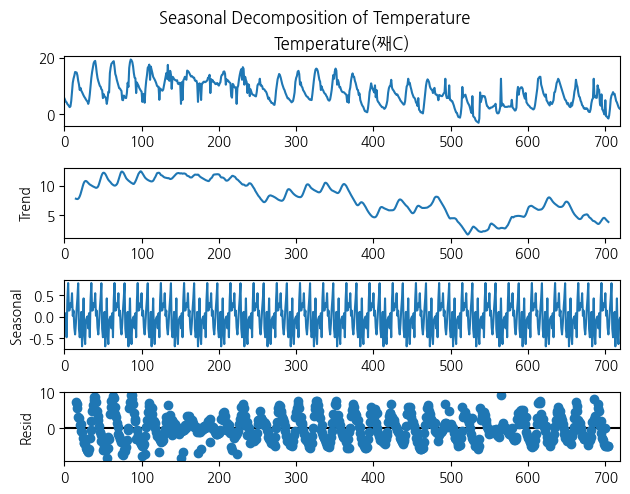

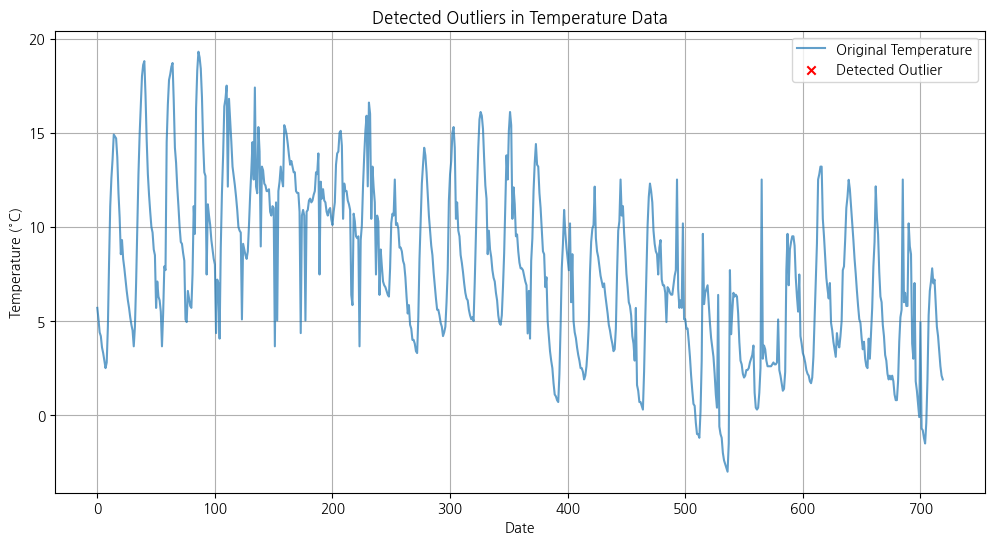

In [258]:
 #1. 계절성 분해 
from statsmodels.tsa.seasonal import seasonal_decompose
    
decomp_result = seasonal_decompose(test['Temperature(째C)'], model='additive', period=30)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

# 4. STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Temperature', y=1.02)
plt.show()

# 5. 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Temperature(째C)'], label='Original Temperature', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, test.loc[outliers.index, 'Temperature(째C)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Detected Outliers in Temperature Data')
plt.grid(True)
plt.show()


이상치 없음

## 습도 이상치 처리

Detected 0 outliers out of 690 data points (0.00% 이상치)


<Figure size 1000x800 with 0 Axes>

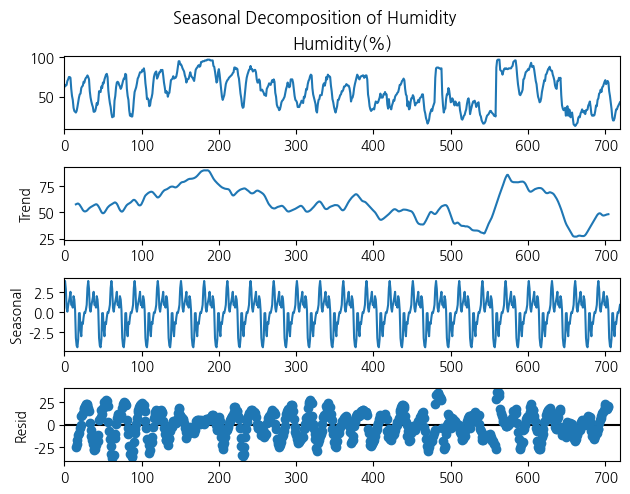

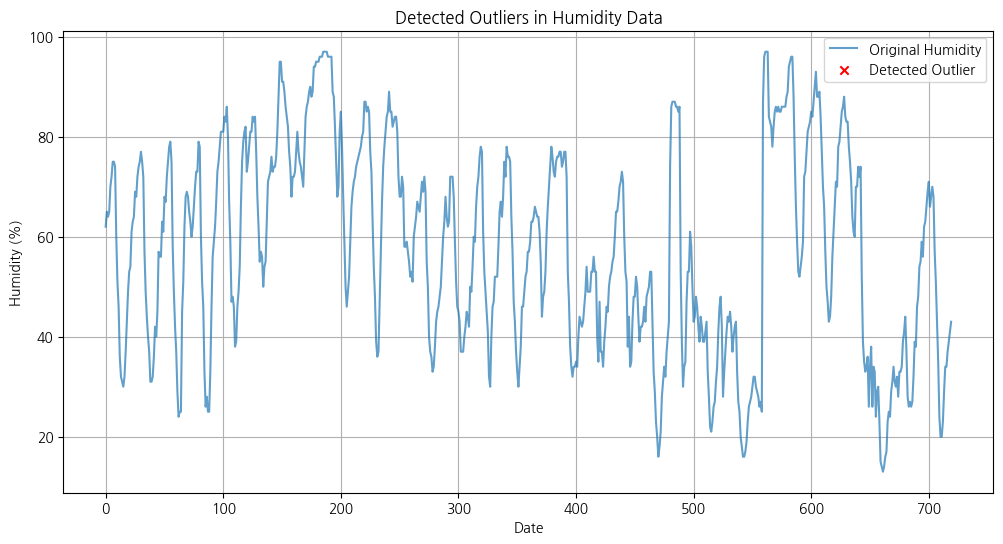

In [259]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. 계절성 분해
decomp_result = seasonal_decompose(test['Humidity(%)'], model='additive', period=30)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

# 4. STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Humidity', y=1.02)
plt.show()

# 5. 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Humidity(%)'], label='Original Humidity', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, test.loc[outliers.index, 'Humidity(%)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Detected Outliers in Humidity Data')
plt.grid(True)
plt.show()


이상치 없음

## 풍속 이상치 처리

Detected 1 outliers out of 690 data points (0.14% 이상치)


<Figure size 1000x800 with 0 Axes>

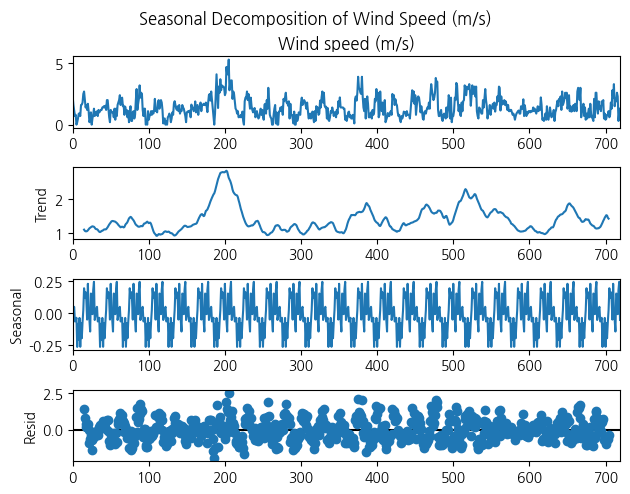

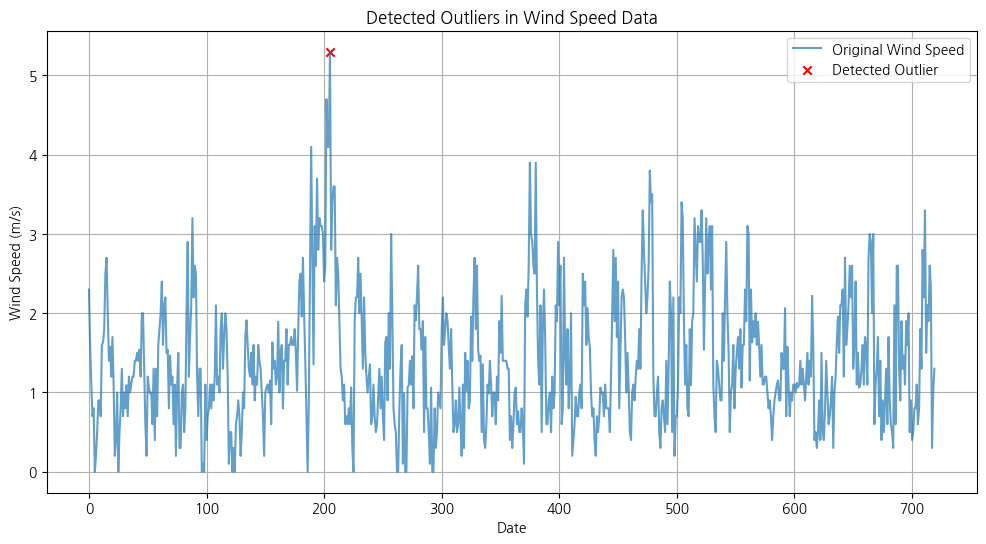

In [260]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. 계절성 분해 
decomp_result = seasonal_decompose(test['Wind speed (m/s)'], model='additive', period=30)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

# 4. STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Wind Speed (m/s)', y=1.02)
plt.show()

# 5. 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Wind speed (m/s)'], label='Original Wind Speed', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, test.loc[outliers.index, 'Wind speed (m/s)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Detected Outliers in Wind Speed Data')
plt.grid(True)
plt.show()

#1개 이상치 발견

In [261]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = test.loc[outliers.index]

# 결과 출력

pd.DataFrame(outlier_rows) 

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
205,2018-11-09,13,14.0,46,5.3,927,2.5,1.68,0.0,0.0,2,0,0


풍속이 5.3m/s은 일상적인 범위에 속하기에 이상치로 간주하지 않는다.

## 가시거리 이상치 처리

Detected 7 outliers out of 690 data points (1.01% 이상치)


<Figure size 1000x800 with 0 Axes>

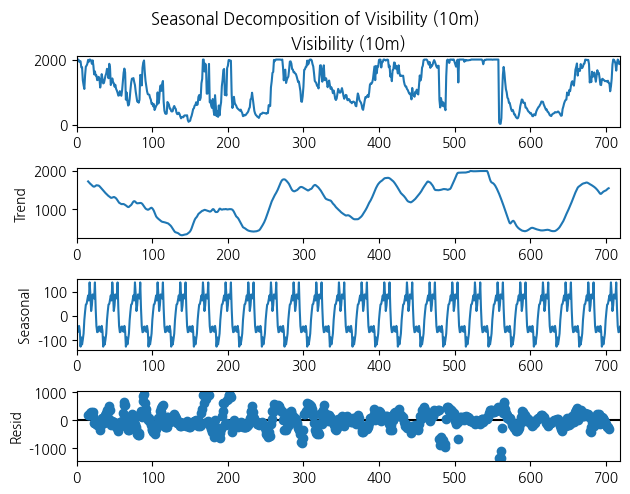

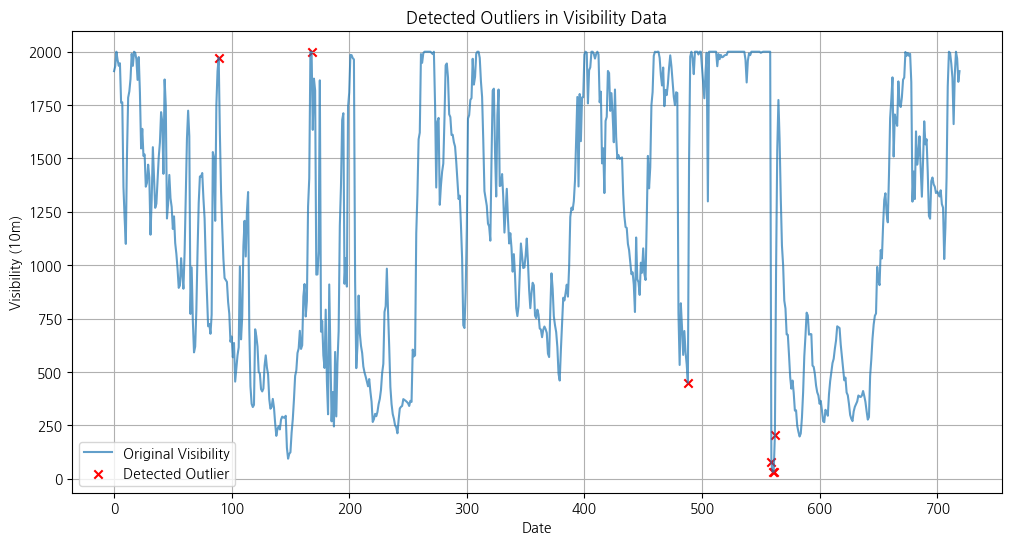

In [262]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. 계절성 분해
decomp_result = seasonal_decompose(test['Visibility (10m)'], model='additive', period=30)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

# 4. STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Visibility (10m)', y=1.02)
plt.show()

# 5. 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Visibility (10m)'], label='Original Visibility', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, test.loc[outliers.index, 'Visibility (10m)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Visibility (10m)')
plt.title('Detected Outliers in Visibility Data')
plt.grid(True)
plt.show()


In [263]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = test.loc[outliers.index]

# 결과 출력

pd.DataFrame(outlier_rows) 

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
89,2018-11-04,17,16.9,33,2.200000,1972,0.5,0.43,0.0,0.0,2,0,1
168,2018-11-08,0,12.9,70,1.800000,2000,7.5,0.00,0.0,0.0,2,0,1
488,2018-11-21,8,6.4,86,0.900000,450,4.2,0.03,0.0,0.0,2,0,1
559,2018-11-24,7,1.2,87,1.900000,77,-0.7,0.00,0.0,1.3,2,0,1
560,2018-11-24,8,0.4,96,3.100000,33,-0.1,0.00,0.0,4.0,2,0,1
561,2018-11-24,9,0.3,97,3.000000,34,-0.1,0.00,9.1,7.1,2,0,1
562,2018-11-24,10,0.4,97,1.151852,207,0.0,0.00,0.0,8.8,2,0,1


가시거리가 낮은 이유는 비가 오거나 눈이 오기 때문이기 때문이고, 보통 도심에서 가시거리는 1000~2000m 이므로 이상치로 간주할것이 없다 판단 

## 이슬점 온도 이상치 처리

Detected 11 outliers out of 690 data points (1.59% 이상치)


<Figure size 1000x800 with 0 Axes>

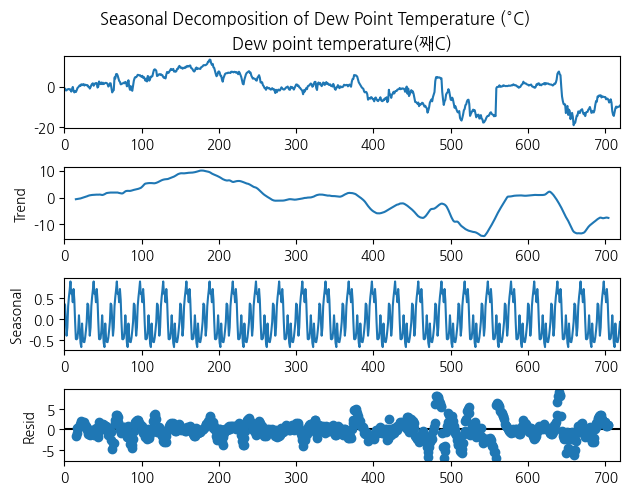

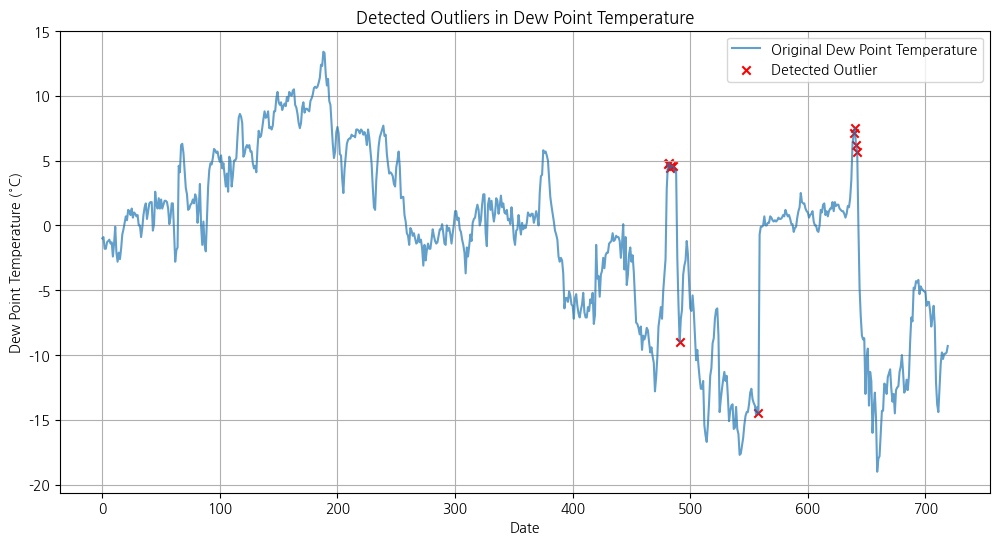

In [264]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. STL 계절성 분해 
decomp_result = seasonal_decompose(test['Dew point temperature(째C)'], model='additive', period=30)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

# 4. STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Dew Point Temperature (°C)', y=1.02)
plt.show()

# 5. 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Dew point temperature(째C)'], label='Original Dew Point Temperature', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, test.loc[outliers.index, 'Dew point temperature(째C)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Dew Point Temperature (°C)')
plt.title('Detected Outliers in Dew Point Temperature')
plt.grid(True)
plt.show()


In [265]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = test.loc[outliers.index]

# 결과 출력

pd.DataFrame(outlier_rows) 

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
481,2018-11-21,1,6.900000,86,0.7,533,4.7,0.00,0.0,0.0,2,0,1
482,2018-11-21,2,6.900000,87,0.7,822,4.8,0.00,0.0,0.0,2,0,1
483,2018-11-21,3,6.500000,87,1.0,710,4.4,0.00,1.0,0.0,2,0,1
484,2018-11-21,4,4.944444,87,1.2,580,4.6,0.00,0.0,0.0,2,0,1
485,2018-11-21,5,6.800000,86,0.5,692,4.6,0.00,0.0,0.0,2,0,1
491,2018-11-21,11,7.400000,30,1.4,2000,-9.0,0.44,0.0,0.0,2,0,1
558,2018-11-24,6,3.700000,25,2.3,2000,-14.5,0.00,0.0,0.0,2,0,1
639,2018-11-27,15,12.500000,70,2.1,360,7.1,0.68,0.0,0.0,2,0,1
640,2018-11-27,16,12.000000,74,2.1,316,7.5,0.29,0.0,0.0,2,0,1
641,2018-11-27,17,11.100000,72,2.3,277,6.2,0.12,0.0,0.0,2,0,1


491행 (-9.0°C), 558행 (-14.5°C)
- 이 두 값은 주변 온도 대비 매우 낮으며, 일반적인 기상 조건에서는 비현실적일 수 있습니다.
- 특히 558행은 주위 온도가 3.7°C인데 이슬점이 -14.5°C로, 상대 습도 25%에서는 비정상적입니다. -> 두 값 제거

In [266]:
# 제거할 행 인덱스를 지정
rows_to_remove = [491, 558]

# 해당 행을 제거하고 새로운 DataFrame으로 저장
test = test.drop(index=rows_to_remove)

# 제거 결과 확인
print("제거된 후 데이터 크기:", test.shape)


제거된 후 데이터 크기: (718, 13)


## 태양 복사랑 이상치 처리

Detected 0 outliers out of 688 data points (0.00% 이상치)


<Figure size 1000x800 with 0 Axes>

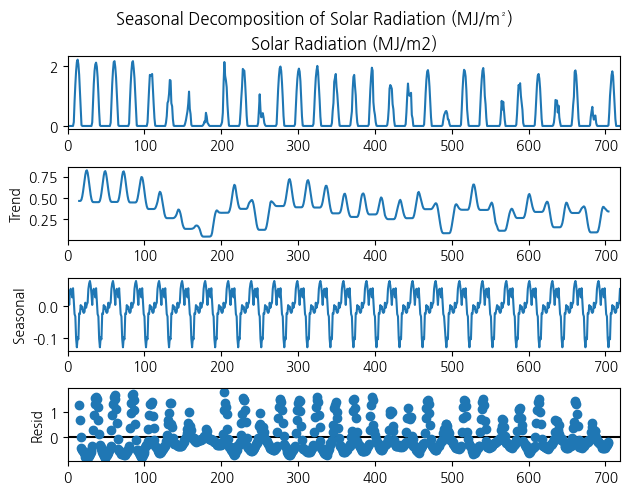

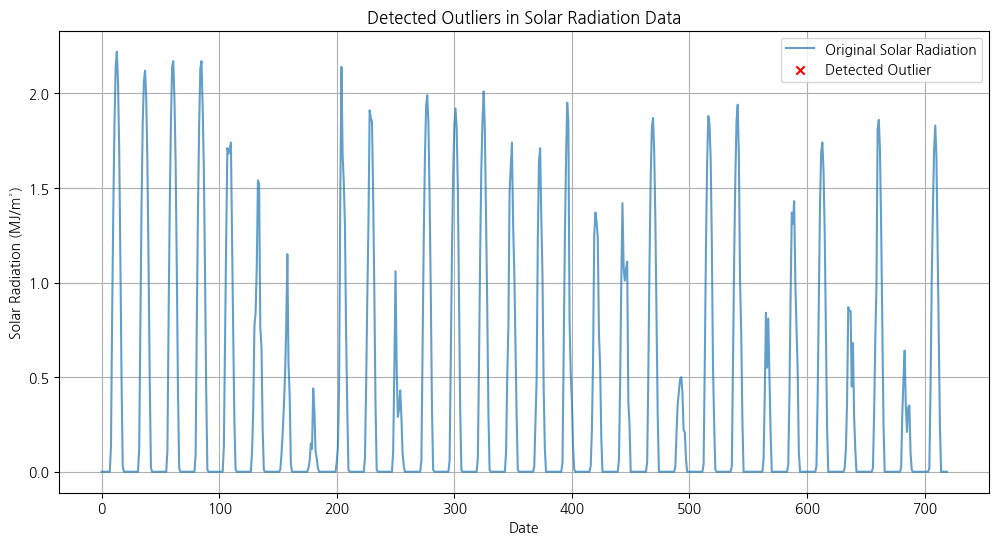

In [267]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. STL 계절성 분해 
decomp_result = seasonal_decompose(test['Solar Radiation (MJ/m2)'], model='additive', period=30)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

# 4. STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Solar Radiation (MJ/m²)', y=1.02)
plt.show()

# 5. 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Solar Radiation (MJ/m2)'], label='Original Solar Radiation', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, test.loc[outliers.index, 'Solar Radiation (MJ/m2)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Solar Radiation (MJ/m²)')
plt.title('Detected Outliers in Solar Radiation Data')
plt.grid(True)
plt.show()


이상치 없음

## 강우량 이상치 처리

Detected 6 outliers out of 688 data points (0.87% 이상치)


<Figure size 1000x800 with 0 Axes>

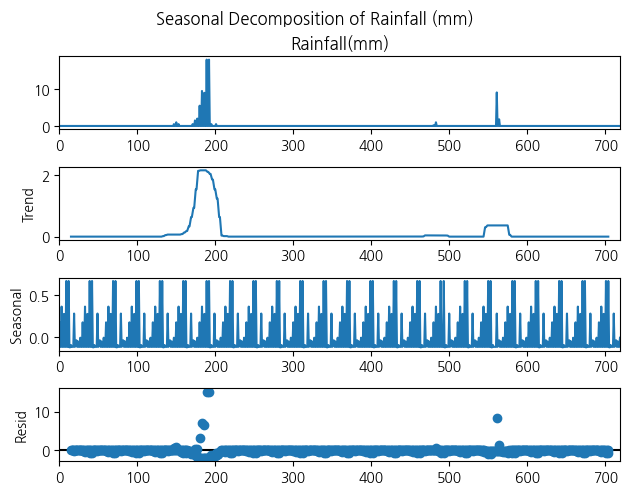

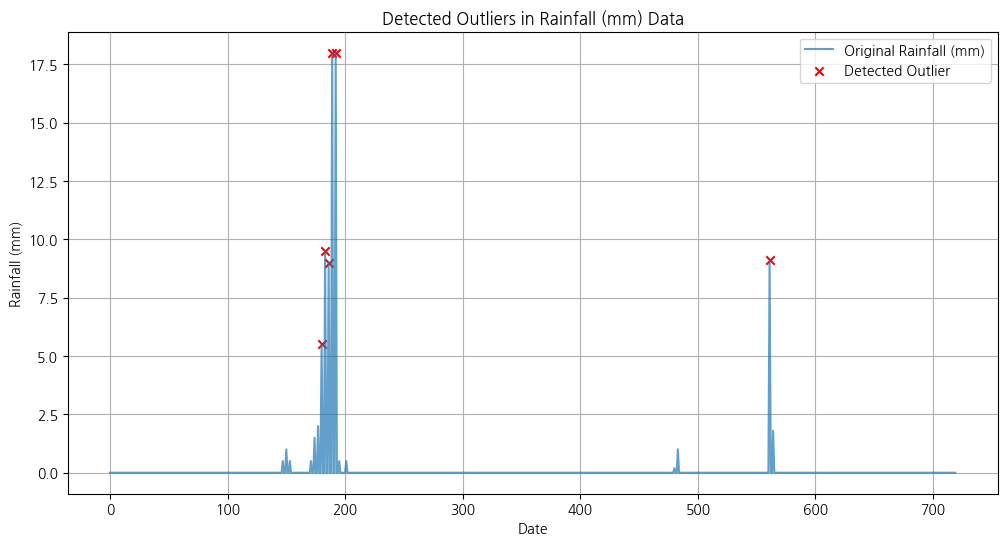

In [268]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. STL 계절성 분해 
decomp_result = seasonal_decompose(test['Rainfall(mm)'], model='additive', period=30)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

# 4. STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Rainfall (mm)', y=1.02)
plt.show()

# 5. 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Rainfall(mm)'], label='Original Rainfall (mm)', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, test.loc[outliers.index, 'Rainfall(mm)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Detected Outliers in Rainfall (mm) Data')
plt.grid(True)
plt.show()

In [269]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = test.loc[outliers.index]

# 결과 출력

pd.DataFrame(outlier_rows)  

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
180,2018-11-08,12,11.400,95,2.5,792,10.6,0.44,5.5,0.0,2,0,1
183,2018-11-08,15,11.400,96,2.0,910,10.7,0.07,9.5,0.0,2,0,1
186,2018-11-08,18,12.900,97,0.0,406,12.4,0.00,9.0,0.0,2,0,1
189,2018-11-08,21,7.472,96,4.1,292,13.3,0.00,18.0,0.0,2,0,1
192,2018-11-09,0,12.000,96,3.1,1185,11.3,0.00,18.0,0.0,2,0,0
561,2018-11-24,9,0.300,97,3.0,34,-0.1,0.00,9.1,7.1,2,0,1


모두 습도가 엄청 높으므로 이상치가 아니라는 판단

## 적설량 이상치 처리

Detected 13 outliers out of 688 data points (1.89% 이상치)


<Figure size 1000x800 with 0 Axes>

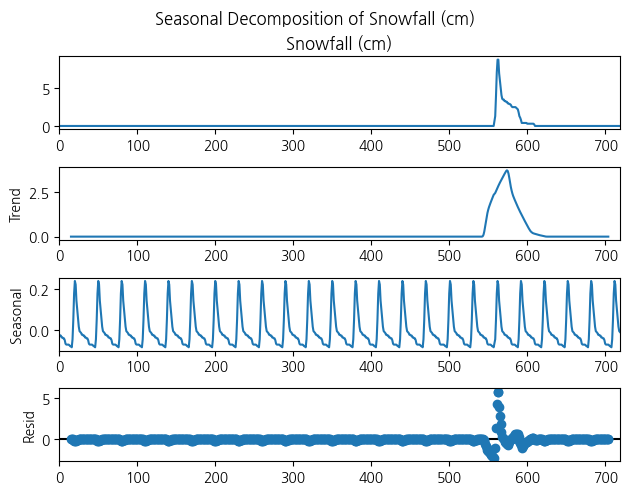

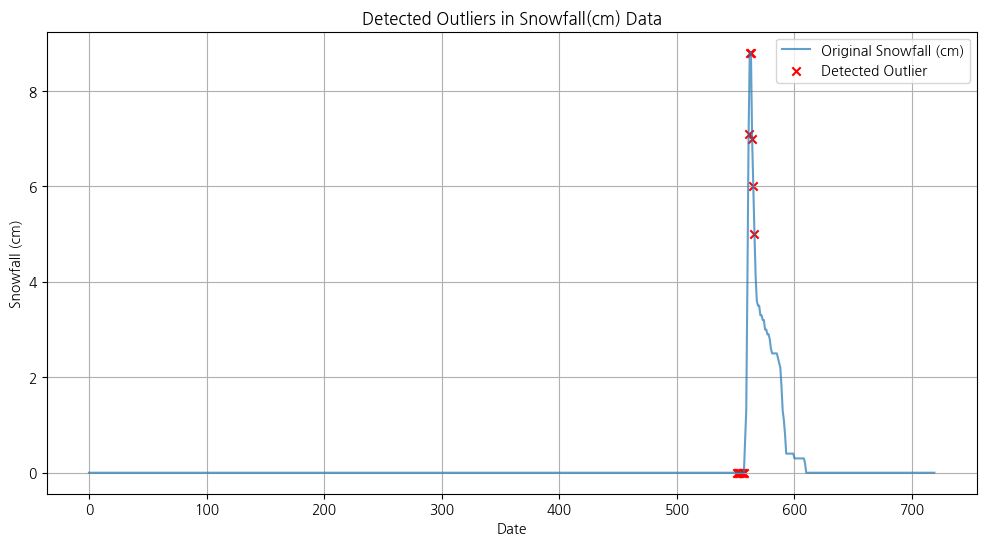

In [270]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. STL 계절성 분해 
decomp_result = seasonal_decompose(test['Snowfall (cm)'], model='additive', period=30)

# 2. 잔차 추출 및 이상치 기준 설정 (잔차가 평균 ± 3배 표준편차를 벗어나는 값)
residuals = decomp_result.resid.dropna()
outlier_threshold = residuals.std() * 3
outliers = residuals[abs(residuals) > outlier_threshold]

# 3. 이상치 개수 및 비율 출력
print(f"Detected {len(outliers)} outliers out of {len(residuals)} data points ({len(outliers) / len(residuals) * 100:.2f}% 이상치)")

# 4. STL 분해 결과 시각화 (추세, 계절성, 잔차)
plt.figure(figsize=(10, 8))
decomp_result.plot()
plt.suptitle('Seasonal Decomposition of Snowfall (cm)', y=1.02)
plt.show()

# 5. 이상치와 원본 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Snowfall (cm)'], label='Original Snowfall (cm)', color='tab:blue', alpha=0.7)
plt.scatter(outliers.index, test.loc[outliers.index, 'Snowfall (cm)'], color='red', label='Detected Outlier', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Snowfall (cm)')
plt.title('Detected Outliers in Snowfall(cm) Data')
plt.grid(True)
plt.show()

In [271]:
# 이상치로 판별된 행 전체를 출력
outlier_rows = test.loc[outliers.index]

# 결과 출력

pd.DataFrame(outlier_rows)  

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
551,2018-11-23,23,2.100000,32,1.500000,1998,-12.9,0.00,0.0,0.0,2,0,1
552,2018-11-24,0,2.400000,32,1.700000,2000,-12.6,0.00,0.0,0.0,2,0,1
553,2018-11-24,1,2.400000,30,1.300000,2000,-13.4,0.00,0.0,0.0,2,0,1
554,2018-11-24,2,2.500000,29,1.800000,2000,-13.7,0.00,0.0,0.0,2,0,1
555,2018-11-24,3,2.800000,28,1.061905,2000,-13.9,0.00,0.0,0.0,2,0,1
556,2018-11-24,4,3.000000,26,1.600000,2000,-14.6,0.00,0.0,0.0,2,0,1
557,2018-11-24,5,3.200000,27,1.600000,2000,-14.0,0.00,0.0,0.0,2,0,1
561,2018-11-24,9,0.300000,97,3.000000,34,-0.1,0.00,9.1,7.1,2,0,1
562,2018-11-24,10,0.400000,97,1.151852,207,0.0,0.00,0.0,8.8,2,0,1
563,2018-11-24,11,1.200000,97,2.300000,975,0.7,0.07,0.0,8.8,2,0,1


565행이 적설량이 높은데 기온이 12도이므로 이상치라고 판단하고 삭제한다.

In [272]:
# 제거할 행 인덱스를 지정
rows_to_remove = 565

# 해당 행을 제거하고 새로운 DataFrame으로 저장
test = test.drop(index=rows_to_remove)

print(test.shape)


(717, 13)


# 최적의 회귀 모델 test셋에 적용

In [273]:
#test셋의 변수 정의
features = [
    'Hour', 
    'Temperature(째C)', 
    'Humidity(%)', 
    'Wind speed (m/s)', 
    'Visibility (10m)', 
    'Dew point temperature(째C)',
    'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 
    'Snowfall (cm)',
    'Seasons', 
    'Holiday', 
    'Functioning Day'
]

In [274]:
# 최종 모델
final_model= GradientBoostingRegressor(random_state=42, n_estimators= 200, max_depth=5, learning_rate=0.1)

In [275]:
# 모델 학습
final_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [276]:
test['Rented Bike Count'] = final_model.predict(test[features])

In [277]:
# test 데이터로 예측 
print(test[['Rented Bike Count']].head())

   Rented Bike Count
0         555.646203
1         440.722903
2         358.960892
3         273.769848
4         239.281410


In [278]:
# 정수로 변환
test['Rented Bike Count'] = test['Rented Bike Count'].astype(int)

In [279]:
test.head()

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Rented Bike Count
0,2018-11-01,0,5.7,62,2.300000,1909,-1.0,0.0,0.0,0.0,2,0,1,555
1,2018-11-01,1,5.1,65,1.600000,1932,-0.9,0.0,0.0,0.0,2,0,1,440
2,2018-11-01,2,4.4,64,1.121429,2000,-1.8,0.0,0.0,0.0,2,0,1,358
3,2018-11-01,3,4.2,65,0.700000,1962,-1.8,0.0,0.0,0.0,2,0,1,273
4,2018-11-01,4,3.6,70,0.800000,1934,-1.3,0.0,0.0,0.0,2,0,1,239
